In [306]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Import all required libraries and modules

In [307]:

import os 
import sys
# import shap
import optuna
from dotenv import load_dotenv
from scipy.stats import shapiro, norm, mannwhitneyu
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd 
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler

sys.path.append("/Users/nikolaynechay/Iris-Species")
# sys.path.append("/home/nikolay/Deloitte/project_task/Iris")

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

load_dotenv()

False

### Import all required modules

In [308]:

from src.core.helpers.model_evaluation import evaluate_model
from src.core.helpers.error_analysis import create_detailed_analysis, analyze_classification_errors_simple
from src.core.helpers.ea_hist_by_target import plot_error_distribution
from src.core.helpers.visualizations import plot_distributions_of_feature_by_classes, plot_boxplot_with_missclassifications
from src.core.helpers.feature_engineering import generate_new_features
from src.core.helpers.optuna_objective import objective_for_logistic_regression, objective_for_bagging_classifier
from src.core.helpers.calculate_boundaries import compress_boundaries_by_class

# Data Collection

### Setting required Global Variables

In [309]:
# IRIS_PATH = os.getenv("IRIS_PATH", "src/core/datafiles/raw/Iris.csv")
IRIS_PATH = "/Users/nikolaynechay/Iris-Species/src/core/datafiles/raw/Iris.csv"

### Load dataset

In [310]:
iris_df = pd.read_csv(IRIS_PATH)
iris_df.drop('Id', axis=1, inplace=True)  # Delete ID column
iris_df.iloc[:5]

SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm      Species
0            5.1           3.5            1.4           0.2  Iris-setosa
1            4.9           3.0            1.4           0.2  Iris-setosa
2            4.7           3.2            1.3           0.2  Iris-setosa
3            4.6           3.1            1.5           0.2  Iris-setosa
4            5.0           3.6            1.4           0.2  Iris-setosa

### Sampling Training and Testing Datasets

To ensure robust evaluation, the dataset was stratified and split into training and testing subsets.  
Stratification preserves the original class distribution

In [311]:

species_label_encoder = LabelEncoder()

iris_measurements = iris_df.drop('Species', axis=1)
species_labels = species_label_encoder.fit_transform(iris_df['Species'])

train_measurements, test_measurements, train_species_labels, test_species_labels = train_test_split(
    iris_measurements,
    species_labels,
    test_size=0.2,
    random_state=41,
    stratify=species_labels
)
train_measurements.iloc[:5]
target_dict = dict(zip(species_label_encoder.transform(species_label_encoder.classes_), species_label_encoder.classes_))
print(target_dict)


{0: 'Iris-setosa', 1: 'Iris-versicolor', 2: 'Iris-virginica'}


The dataset was splitted into training and testing subsets. This prepares the data for model training and evaluation while ensuring that the class distribution is preserved, enabling a fair assessment of model performance.


# Baseline section

As a starting point, I will build a baseline model.  
This model will serve as a reference point for evaluating all future experiments and decisions.

The baseline model defines a minimum acceptable performance threshold.  
Any further improvements or changes to the modeling pipeline should demonstrate measurable gains over this baseline to be considered valid.

### Model building

The baseline model is a logistic regression classifier with the following configuration:

- **Regularization**: L2 (Ridge), to penalize large coefficients and reduce overfitting.
- **Optimization algorithm**: LBFGS
- **Max iterations**: 50, to ensure convergence within a reasonable time frame.

This model establishes the initial benchmark for evaluating future enhancements.

In [312]:
baseline_model = LogisticRegression(max_iter=50, random_state=42)
baseline_model.fit(train_measurements, train_species_labels)

baseline_train_df_with_predictions, baseline_train_accuracy, baseline_train_precision, baseline_train_recall, baseline_train_f1 = evaluate_model(train_measurements, train_species_labels, baseline_model)
baseline_test_df_with_predictions, baseline_test_accuracy, baseline_test_precision, baseline_test_recall, baseline_test_f1 = evaluate_model(test_measurements, test_species_labels, baseline_model)

print("Baseline model evaluation:")
print(f"Train Accuracy: {baseline_train_accuracy:.4f}")
print(f"Train Precision: {baseline_train_precision:.4f}")
print(f"Train Recall: {baseline_train_recall:.4f}")
print(f"Train F1: {baseline_train_f1:.4f}")
print('---------------------')
print(f"Test Accuracy: {baseline_test_accuracy:.4f}")
print(f"Test Precision: {baseline_test_precision:.4f}")
print(f"Test Recall: {baseline_test_recall:.4f}")
print(f"Test F1: {baseline_test_f1:.4f}")

Baseline model evaluation:
Train Accuracy: 0.9750
Train Precision: 0.9752
Train Recall: 0.9750
Train F1: 0.9750
---------------------
Test Accuracy: 0.9333
Test Precision: 0.9333
Test Recall: 0.9333
Test F1: 0.9333


/Users/nikolaynechay/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Error Analysis

##### Distribution of correct and incorrect predictions on train set

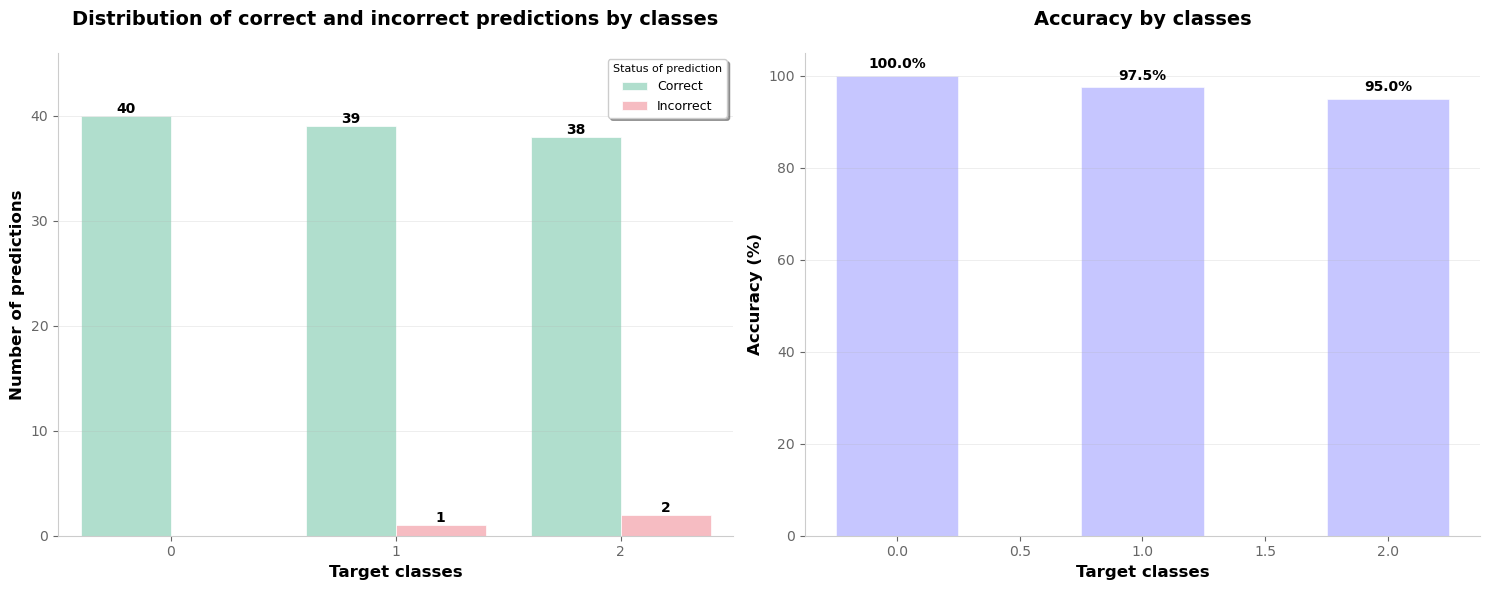

In [313]:
plot_error_distribution(baseline_train_df_with_predictions['predicted_label'], train_species_labels)

The model demonstrates high classification accuracy on the train set: 100% for class 0, 97.5% for class 1, and 95% for class 2. Potential issues: feature overlap with other classes.

##### Distribution of correct and incorrect predictions on test set

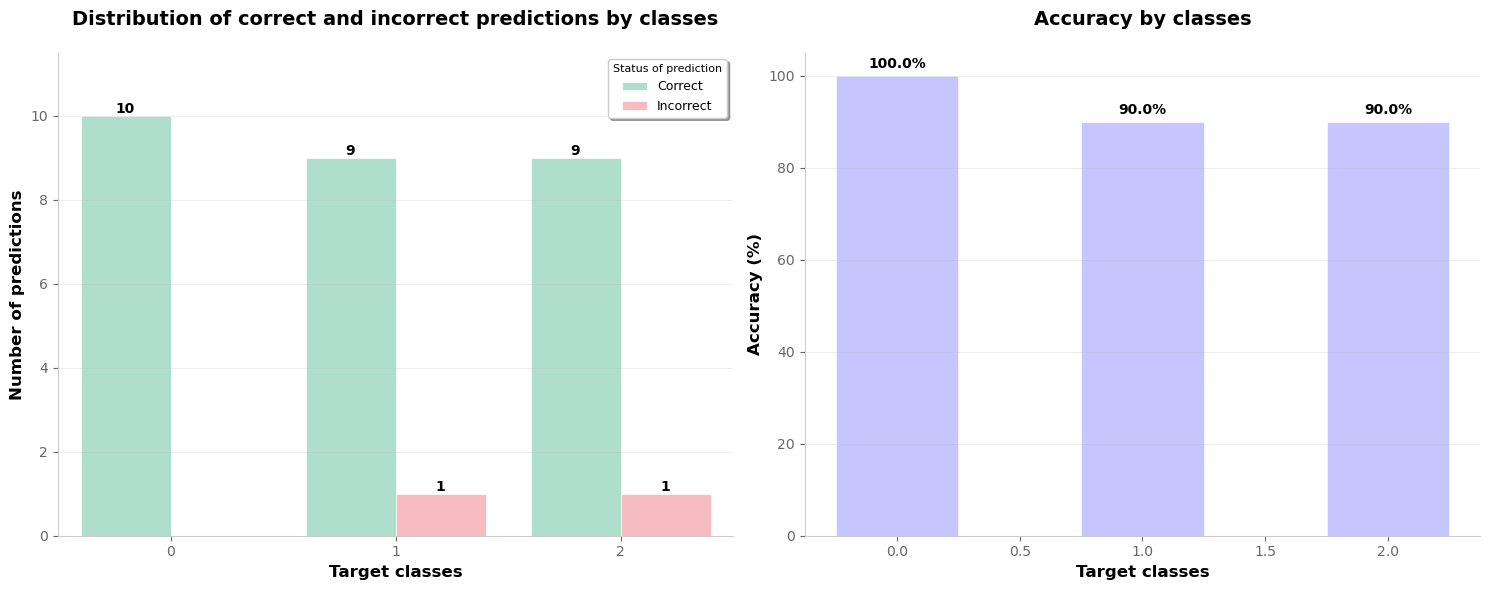

In [314]:
plot_error_distribution(baseline_test_df_with_predictions['predicted_label'], test_species_labels)

The model demonstrates high classification accuracy on test set: 100% for class 0, 90% for class 1, and 90% for class 2.

##### Create dataframe for error classifications on train set

In [315]:
baseline_train_df_errors = baseline_train_df_with_predictions[baseline_train_df_with_predictions['is_correct'] == False]
baseline_train_df_errors.iloc[:]

SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm  true_label  \
106            4.9           2.5            4.5           1.7           2   
83             6.0           2.7            5.1           1.6           1   
119            6.0           2.2            5.0           1.5           2   

     predicted_label  probability_of_0  probability_of_1  probability_of_2  \
106                1             0.004             0.562             0.434   
83                 2             0.001             0.420             0.579   
119                1             0.001             0.600             0.399   

     is_correct  
106       False  
83        False  
119       False

##### Create dataframe for error classifications on test set

In [316]:
baseline_test_df_errors = baseline_test_df_with_predictions[baseline_test_df_with_predictions['is_correct'] == False]
baseline_test_df_errors.iloc[:]

SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm  true_label  \
70             5.9           3.2            4.8           1.8           1   
133            6.3           2.8            5.1           1.5           2   

     predicted_label  probability_of_0  probability_of_1  probability_of_2  \
70                 2             0.004             0.412             0.584   
133                1             0.001             0.542             0.456   

     is_correct  
70        False  
133       False

##### Extract weights and bias from baseline model

In [317]:
baseline_weights = baseline_model.coef_
baseline_bias = baseline_model.intercept_
baseline_feature_names = train_measurements.columns.tolist()

print(f"Baseline\nWeights: {baseline_weights}\nBias: {baseline_bias}")

Baseline
Weights: [[ 0.21367371  0.77728805 -2.45584691 -1.01756082]
 [ 0.25086047 -0.53925165 -0.11524461 -1.02615973]
 [-0.46453417 -0.2380364   2.57109153  2.04372055]]
Bias: [  6.63242277   4.0906008  -10.72302357]


##### Create detailed analysis dataframe by baseline model 

In [318]:
baseline_train_detailed_df = create_detailed_analysis(baseline_train_df_with_predictions, baseline_weights, baseline_bias, baseline_feature_names)
baseline_test_detailed_df = create_detailed_analysis(baseline_test_df_with_predictions, baseline_weights, baseline_bias, baseline_feature_names)
print(baseline_train_detailed_df.shape)
print(baseline_test_detailed_df.shape)
baseline_train_detailed_df.head()

(120, 45)
(30, 45)


original_idx  true_label  predicted_label  logit_class_0  \
0           123           2                2         -3.788   
1           106           2                1         -3.159   
2           149           2                2         -4.131   
3            10           0                0          6.775   
4            98           1                1          1.179   

   probability_class_0  bias_class_0  logit_class_1  probability_class_1  \
0                0.002         6.632          1.803                0.454   
1                0.004         6.632          1.709                0.562   
2                0.001         6.632          1.518                0.250   
3                0.976         6.632          3.072                0.024   
4                0.203         6.632          2.547                0.796   

   bias_class_1  logit_class_2  probability_class_2  bias_class_2  \
0         4.091          1.985                0.544       -10.723   
1         4.091          1.450                0.434       -10.723   
2         4.091          2.613                0.749       -10.723   
3         4.091         -9.847                0.000       -10.723   
4         4.091         -3.726                0.002       -10.723   

   SepalLengthCm_value  SepalLengthCm_contribution_class_0  \
0                  6.3                               1.346   
1                  4.9                               1.047   
2                  5.9                               1.261   
3                  5.4                               1.154   
4                  5.1                               1.090   

   SepalLengthCm_weight_class_0  SepalLengthCm_contribution_class_1  \
0                         0.214                               1.580   
1                         0.214                               1.229   
2                         0.214                               1.480   
3                         0.214                               1.355   
4                         0.214                               1.279   

   SepalLengthCm_weight_class_1  SepalLengthCm_contribution_class_2  \
0                         0.251                              -2.927   
1                         0.251                              -2.276   
2                         0.251                              -2.741   
3                         0.251                              -2.508   
4                         0.251                              -2.369   

   SepalLengthCm_weight_class_2  SepalWidthCm_value  \
0                        -0.465                 2.7   
1                        -0.465                 2.5   
2                        -0.465                 3.0   
3                        -0.465                 3.7   
4                        -0.465                 2.5   

   SepalWidthCm_contribution_class_0  SepalWidthCm_weight_class_0  \
0                              2.099                        0.777   
1                              1.943                        0.777   
2                              2.332                        0.777   
3                              2.876                        0.777   
4                              1.943                        0.777   

   SepalWidthCm_contribution_class_1  SepalWidthCm_weight_class_1  \
0                             -1.456                       -0.539   
1                             -1.348                       -0.539   
2                             -1.618                       -0.539   
3                             -1.995                       -0.539   
4                             -1.348                       -0.539   

   SepalWidthCm_contribution_class_2  SepalWidthCm_weight_class_2  \
0                             -0.643                       -0.238   
1                             -0.595                       -0.238   
2                             -0.714                       -0.238   
3                             -0.881                       -0.238   
4                  

##### Dataframe with missclassifications on train set

In [319]:
baseline_train_error_df = baseline_train_detailed_df[baseline_train_detailed_df['true_label'] != baseline_train_detailed_df['predicted_label']]
print(list(baseline_train_error_df.columns))
print(baseline_train_error_df.shape)
baseline_train_error_df.head(10)

['original_idx', 'true_label', 'predicted_label', 'logit_class_0', 'probability_class_0', 'bias_class_0', 'logit_class_1', 'probability_class_1', 'bias_class_1', 'logit_class_2', 'probability_class_2', 'bias_class_2', 'SepalLengthCm_value', 'SepalLengthCm_contribution_class_0', 'SepalLengthCm_weight_class_0', 'SepalLengthCm_contribution_class_1', 'SepalLengthCm_weight_class_1', 'SepalLengthCm_contribution_class_2', 'SepalLengthCm_weight_class_2', 'SepalWidthCm_value', 'SepalWidthCm_contribution_class_0', 'SepalWidthCm_weight_class_0', 'SepalWidthCm_contribution_class_1', 'SepalWidthCm_weight_class_1', 'SepalWidthCm_contribution_class_2', 'SepalWidthCm_weight_class_2', 'PetalLengthCm_value', 'PetalLengthCm_contribution_class_0', 'PetalLengthCm_weight_class_0', 'PetalLengthCm_contribution_class_1', 'PetalLengthCm_weight_class_1', 'PetalLengthCm_contribution_class_2', 'PetalLengthCm_weight_class_2', 'PetalWidthCm_value', 'PetalWidthCm_contribution_class_0', 'PetalWidthCm_weight_class_0', 

original_idx  true_label  predicted_label  logit_class_0  \
1             106           2                1         -3.159   
10             83           1                2         -4.140   
113           119           2                1         -4.181   

     probability_class_0  bias_class_0  logit_class_1  probability_class_1  \
1                  0.004         6.632          1.709                0.562   
10                 0.001         6.632          1.910                0.420   
113                0.001         6.632          2.294                0.600   

     bias_class_1  logit_class_2  probability_class_2  bias_class_2  \
1           4.091          1.450                0.434       -10.723   
10          4.091          2.230                0.579       -10.723   
113         4.091          1.887                0.399       -10.723   

     SepalLengthCm_value  SepalLengthCm_contribution_class_0  \
1                    4.9                               1.047   
10                   6.0                               1.282   
113                  6.0                               1.282   

     SepalLengthCm_weight_class_0  SepalLengthCm_contribution_class_1  \
1                           0.214                               1.229   
10                          0.214                               1.505   
113                         0.214                               1.505   

     SepalLengthCm_weight_class_1  SepalLengthCm_contribution_class_2  \
1                           0.251                              -2.276   
10                          0.251                              -2.787   
113                         0.251                              -2.787   

     SepalLengthCm_weight_class_2  SepalWidthCm_value  \
1                          -0.465                 2.5   
10                         -0.465                 2.7   
113                        -0.465                 2.2   

     SepalWidthCm_contribution_class_0  SepalWidthCm_weight_class_0  \
1                                1.943                        0.777   
10                               2.099                        0.777   
113                              1.710                        0.777   

     SepalWidthCm_contribution_class_1  SepalWidthCm_weight_class_1  \
1                               -1.348                       -0.539   
10                              -1.456                       -0.539   
113                             -1.186                       -0.539   

     SepalWidthCm_contribution_class_2  SepalWidthCm_weight_class_2  \
1                               -0.595                       -0.238   
10                              -0.643                       -0.238   
113                             -0.524                       -0.238   

     PetalLengthCm_value  PetalLengthCm_contribution_class_0  \
1                    4.5                             -11.051   
10                   5.1                             -12.525   
113                  5.0                             -12.279   

     PetalLengthCm_weight_class_0  PetalLengthCm_contribution_class_1  \
1                          -2.456                              -0.519   
10                         -2.456                              -0.588   
113                        -2.456                              -0.576   

     PetalLengthCm_weight_class_1  PetalLengthCm_contribution_class_2  \
1                          -0.115                              11.570   
10                         -0.115                              13.113   
113                        -0.115                              12.855   

     PetalLengthCm_weight_class_2  PetalWidthCm_value  \
1                           2.571                 1.7   
10                          2.571                 1.6   
113                         2.571                 1.5   

     PetalWidthCm_contribution_class_0  PetalWidthCm_weight_class_0  \
1                               -1.730                       -1.018   
10   

##### Dataframe with missclassifications on test set

In [320]:
baseline_test_error_df = baseline_test_detailed_df[baseline_test_detailed_df['true_label'] != baseline_test_detailed_df['predicted_label']]
print(list(baseline_test_error_df.columns))
print(baseline_test_error_df.shape)
baseline_test_error_df.head(10)

['original_idx', 'true_label', 'predicted_label', 'logit_class_0', 'probability_class_0', 'bias_class_0', 'logit_class_1', 'probability_class_1', 'bias_class_1', 'logit_class_2', 'probability_class_2', 'bias_class_2', 'SepalLengthCm_value', 'SepalLengthCm_contribution_class_0', 'SepalLengthCm_weight_class_0', 'SepalLengthCm_contribution_class_1', 'SepalLengthCm_weight_class_1', 'SepalLengthCm_contribution_class_2', 'SepalLengthCm_weight_class_2', 'SepalWidthCm_value', 'SepalWidthCm_contribution_class_0', 'SepalWidthCm_weight_class_0', 'SepalWidthCm_contribution_class_1', 'SepalWidthCm_weight_class_1', 'SepalWidthCm_contribution_class_2', 'SepalWidthCm_weight_class_2', 'PetalLengthCm_value', 'PetalLengthCm_contribution_class_0', 'PetalLengthCm_weight_class_0', 'PetalLengthCm_contribution_class_1', 'PetalLengthCm_weight_class_1', 'PetalLengthCm_contribution_class_2', 'PetalLengthCm_weight_class_2', 'PetalWidthCm_value', 'PetalWidthCm_contribution_class_0', 'PetalWidthCm_weight_class_0', 

original_idx  true_label  predicted_label  logit_class_0  \
7             70           1                2         -3.239   
19           133           2                1         -3.896   

    probability_class_0  bias_class_0  logit_class_1  probability_class_1  \
7                 0.004         6.632          1.445                0.412   
19                0.001         6.632          2.034                0.542   

    bias_class_1  logit_class_2  probability_class_2  bias_class_2  \
7          4.091          1.794                0.584       -10.723   
19         4.091          1.862                0.456       -10.723   

    SepalLengthCm_value  SepalLengthCm_contribution_class_0  \
7                   5.9                               1.261   
19                  6.3                               1.346   

    SepalLengthCm_weight_class_0  SepalLengthCm_contribution_class_1  \
7                          0.214                                1.48   
19                         0.214                                1.58   

    SepalLengthCm_weight_class_1  SepalLengthCm_contribution_class_2  \
7                          0.251                              -2.741   
19                         0.251                              -2.927   

    SepalLengthCm_weight_class_2  SepalWidthCm_value  \
7                         -0.465                 3.2   
19                        -0.465                 2.8   

    SepalWidthCm_contribution_class_0  SepalWidthCm_weight_class_0  \
7                               2.487                        0.777   
19                              2.176                        0.777   

    SepalWidthCm_contribution_class_1  SepalWidthCm_weight_class_1  \
7                              -1.726                       -0.539   
19                             -1.510                       -0.539   

    SepalWidthCm_contribution_class_2  SepalWidthCm_weight_class_2  \
7                              -0.762                       -0.238   
19                             -0.667                       -0.238   

    PetalLengthCm_value  PetalLengthCm_contribution_class_0  \
7                   4.8                             -11.788   
19                  5.1                             -12.525   

    PetalLengthCm_weight_class_0  PetalLengthCm_contribution_class_1  \
7                         -2.456                              -0.553   
19                        -2.456                              -0.588   

    PetalLengthCm_weight_class_1  PetalLengthCm_contribution_class_2  \
7                         -0.115                              12.341   
19                        -0.115                              13.113   

    PetalLengthCm_weight_class_2  PetalWidthCm_value  \
7                          2.571                 1.8   
19                         2.571                 1.5   

    PetalWidthCm_contribution_class_0  PetalWidthCm_weight_class_0  \
7                              -1.832                       -1.018   
19                             -1.526                       -1.018   

    PetalWidthCm_contribution_class_1  PetalWidthCm_weight_class_1  \
7                              -1.847                       -1.026   
19                             -1.539                       -1.026   

    PetalWidthCm_contribution_class_2  PetalWidthCm_weight_class_2  \
7                               3.679                        2.044   
19                              3.066                        2.044   

    contribution_diff_SepalLengthCm  contribution_diff_SepalWidthCm  \
7                            -4.221                           0.964   
19                            4.507                          -0.843   

    contribution_diff_PetalLengthCm  contribution_diff_PetalWidthCm  bias_diff  
7                            12.894                           5.526    -14.814  
19                          -13.700                          -4.605     14.814

##### Train error analysis 

At this stage, I am analyzing the feature contributions, weights, and values that had the most significant impact on the incorrect predictions.

In [321]:
results = analyze_classification_errors_simple(
    df=baseline_train_error_df,
    feature_names=train_measurements.columns.tolist()
)

Analyse classification errors
Number of errors: 3

ERROR #1 (ID: 106.0)
True class: 2 -> Predicted class: 1
Feature contributions (sorted by impact):
  PetalLengthCm  : value=4.50, contribution=-12.089 
  PetalWidthCm   : value=1.70, contribution=-5.219 
  SepalLengthCm  : value=4.90, contribution=3.505 
  SepalWidthCm   : value=2.50, contribution=-0.753 
Main impact: PetalLengthCm (contribution: -12.089)

ERROR #2 (ID: 83.0)
True class: 1 -> Predicted class: 2
Feature contributions (sorted by impact):
  PetalLengthCm  : value=5.10, contribution=13.700 
  PetalWidthCm   : value=1.60, contribution=4.912 
  SepalLengthCm  : value=6.00, contribution=-4.292 
  SepalWidthCm   : value=2.70, contribution=0.813 
Main impact: PetalLengthCm (contribution: 13.700)

ERROR #3 (ID: 119.0)
True class: 2 -> Predicted class: 1
Feature contributions (sorted by impact):
  PetalLengthCm  : value=5.00, contribution=-13.432 
  PetalWidthCm   : value=1.50, contribution=-4.605 
  SepalLengthCm  : value=6.00, 

The misclassifications were primarily driven by the feature `PetalLengthCm`, which had the highest contribution in all errors, either positively or negatively. This suggests the model is overly reliant on this feature, causing confusion between classes 1 and 2.

##### Test error analysis 

In [322]:
results = analyze_classification_errors_simple(
    df=baseline_test_error_df,
    feature_names=test_measurements.columns.tolist()
)

Analyse classification errors
Number of errors: 2

ERROR #1 (ID: 70.0)
True class: 1 -> Predicted class: 2
Feature contributions (sorted by impact):
  PetalLengthCm  : value=4.80, contribution=12.894 
  PetalWidthCm   : value=1.80, contribution=5.526 
  SepalLengthCm  : value=5.90, contribution=-4.221 
  SepalWidthCm   : value=3.20, contribution=0.964 
Main impact: PetalLengthCm (contribution: 12.894)

ERROR #2 (ID: 133.0)
True class: 2 -> Predicted class: 1
Feature contributions (sorted by impact):
  PetalLengthCm  : value=5.10, contribution=-13.700 
  PetalWidthCm   : value=1.50, contribution=-4.605 
  SepalLengthCm  : value=6.30, contribution=4.507 
  SepalWidthCm   : value=2.80, contribution=-0.843 
Main impact: PetalLengthCm (contribution: -13.700)


SUMMARY TABLE OF ERRORS:
----------------------------------------------------------------------
Error    ID    True       Predicted     Main impact     Contribution
---------------------------------------------------------------------

The model exhibits systematic bias in handling PetalLengthCm on train and test sets, which dominates prediction behavior. To improve robustness:

- Consider engineering additional features that decouple this dependency.
- Further investigate of PetalLengthCm feature 

# Working section

This section focuses on developing and testing enhanced models based on insights derived from the baseline model's error analysis.
The objective is to iteratively refine the solution by addressing the identified weaknesses, applying feature engineering, tuning hyperparameters, and experimenting with more advanced algorithms to boost overall performance.

### Feature Engineering 

During the error analysis of the baseline model, it was observed that in all misclassification cases, the model heavily relied on the PetalLengthCm feature, assigning it the highest importance. Additionally, the model needs to be robust to "mutant" inputs — atypical feature values.

To address this, a targeted feature engineering step was introduced. New features were created based on pairwise ratios and interactions between the original features, enhancing the model’s ability to capture non-linear relationships and improve robustness to unusual inputs. From this extended feature set, only those that demonstrated strong class separability were retained. Finally, the top-k most informative features were selected to train the same linear model, aiming for improved generalization and classification performance.

In [323]:
# New feature set
generated_train_measurements, generated_train_species_labels = generate_new_features(
    X=train_measurements,
    y=train_species_labels,
)

generated_test_measurements, generated_test_species_labels = generate_new_features(
    X=test_measurements,
    y=test_species_labels
)

Compressing features set by classes to expand space between distributions and improve linear separability of classes

In [324]:
compressed_train_df, compressed_test_df= compress_boundaries_by_class(
    train_df=pd.concat([generated_train_measurements, generated_train_species_labels], axis=1),
    test_df=pd.concat([generated_test_measurements, generated_test_species_labels], axis=1),
    feature_names=generated_train_measurements.columns.tolist(),
    true_label_col='target',
    compression_factor=0.4,
    quantile_lower=0.05,
    quantile_upper=0.95
)

compressed_train_df.head()

target  compressed_SepalLengthCm  compressed_SepalWidthCm  \
123       2                     5.997                    2.580   
106       2                     4.900                    2.500   
149       2                     5.837                    2.700   
10        0                     4.800                    3.277   
98        1                     5.097                    2.377   

     compressed_PetalLengthCm  compressed_PetalWidthCm  compressed_PetalRatio  \
123                     4.840                    1.737               2.444106   
106                     4.500                    1.697               2.414041   
149                     4.920                    1.737               2.488551   
10                      1.317                    0.140               5.250000   
98                      3.000                    1.040               2.727273   

     compressed_SepalRatio  
123               2.113133  
106               1.960000  
149               1.966467  
10                1.360526  
98                1.934000

New features have been successfully generated, combning original features with pairwise ratios.

### Model building

Current working model is a logistic regression classifier with the following configuration:

- **Regularization**: L2 (Ridge), to penalize large coefficients and reduce overfitting.
- **Optimization algorithm**: LBFGS
- **Max iterations**: 50, to ensure convergence within a reasonable time frame.

In [325]:
working_model = LogisticRegression(max_iter=50, random_state=41)
working_model.fit(compressed_train_df.drop(columns=['target']), compressed_train_df['target'])

working_train_df_with_predictions, working_train_accuracy, working_train_precision, working_train_recall, working_train_f1 = evaluate_model(compressed_train_df.drop(columns=['target']), compressed_train_df['target'], working_model)
working_test_df_with_predictions, working_test_accuracy, working_test_precision, working_test_recall, working_test_f1 = evaluate_model(compressed_test_df.drop(columns=['target']), compressed_test_df['target'], working_model)

print("Working model evaluation:")
print(f"Train Accuracy: {working_train_accuracy:.4f}")
print(f"Train Precision: {working_train_precision:.4f}")
print(f"Train Recall: {working_train_recall:.4f}")
print(f"Train F1: {working_train_f1:.4f}")
print('---------------------')
print(f"Test Accuracy: {working_test_accuracy:.4f}")
print(f"Test Precision: {working_test_precision:.4f}")
print(f"Test Recall: {working_test_recall:.4f}")
print(f"Test F1: {working_test_f1:.4f}")

Working model evaluation:
Train Accuracy: 0.9917
Train Precision: 0.9919
Train Recall: 0.9917
Train F1: 0.9917
---------------------
Test Accuracy: 0.9667
Test Precision: 0.9697
Test Recall: 0.9667
Test F1: 0.9666


/Users/nikolaynechay/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [326]:
# working_model = LogisticRegression(max_iter=50, random_state=41)
# working_model.fit(generated_train_measurements, generated_train_species_labels)

# working_train_df_with_predictions, working_train_accuracy, working_train_precision, working_train_recall, working_train_f1 = evaluate_model(generated_train_measurements, generated_train_species_labels, working_model)
# working_test_df_with_predictions, working_test_accuracy, working_test_precision, working_test_recall, working_test_f1 = evaluate_model(generated_test_measurements, generated_test_species_labels, working_model)

# print("Working model evaluation:")
# print(f"Train Accuracy: {working_train_accuracy:.4f}")
# print(f"Train Precision: {working_train_precision:.4f}")
# print(f"Train Recall: {working_train_recall:.4f}")
# print(f"Train F1: {working_train_f1:.4f}")
# print('---------------------')
# print(f"Test Accuracy: {working_test_accuracy:.4f}")
# print(f"Test Precision: {working_test_precision:.4f}")
# print(f"Test Recall: {working_test_recall:.4f}")
# print(f"Test F1: {working_test_f1:.4f}")

In [327]:
working_train_df_with_predictions.head()

compressed_SepalLengthCm  compressed_SepalWidthCm  \
123                     5.997                    2.580   
106                     4.900                    2.500   
149                     5.837                    2.700   
10                      4.800                    3.277   
98                      5.097                    2.377   

     compressed_PetalLengthCm  compressed_PetalWidthCm  compressed_PetalRatio  \
123                     4.840                    1.737               2.444106   
106                     4.500                    1.697               2.414041   
149                     4.920                    1.737               2.488551   
10                      1.317                    0.140               5.250000   
98                      3.000                    1.040               2.727273   

     compressed_SepalRatio  true_label  predicted_label  probability_of_0  \
123               2.113133           2                2             0.000   
106               1.960000           2                2             0.001   
149               1.966467           2                2             0.000   
10                1.360526           0                0             0.992   
98                1.934000           1                1             0.048   

     probability_of_1  probability_of_2  is_correct  
123             0.136             0.864        True  
106             0.443             0.556        True  
149             0.129             0.871        True  
10              0.008             0.000        True  
98              0.942             0.010        True

### Error Analysis

##### Distribution of correct and incorrect predictions on train set

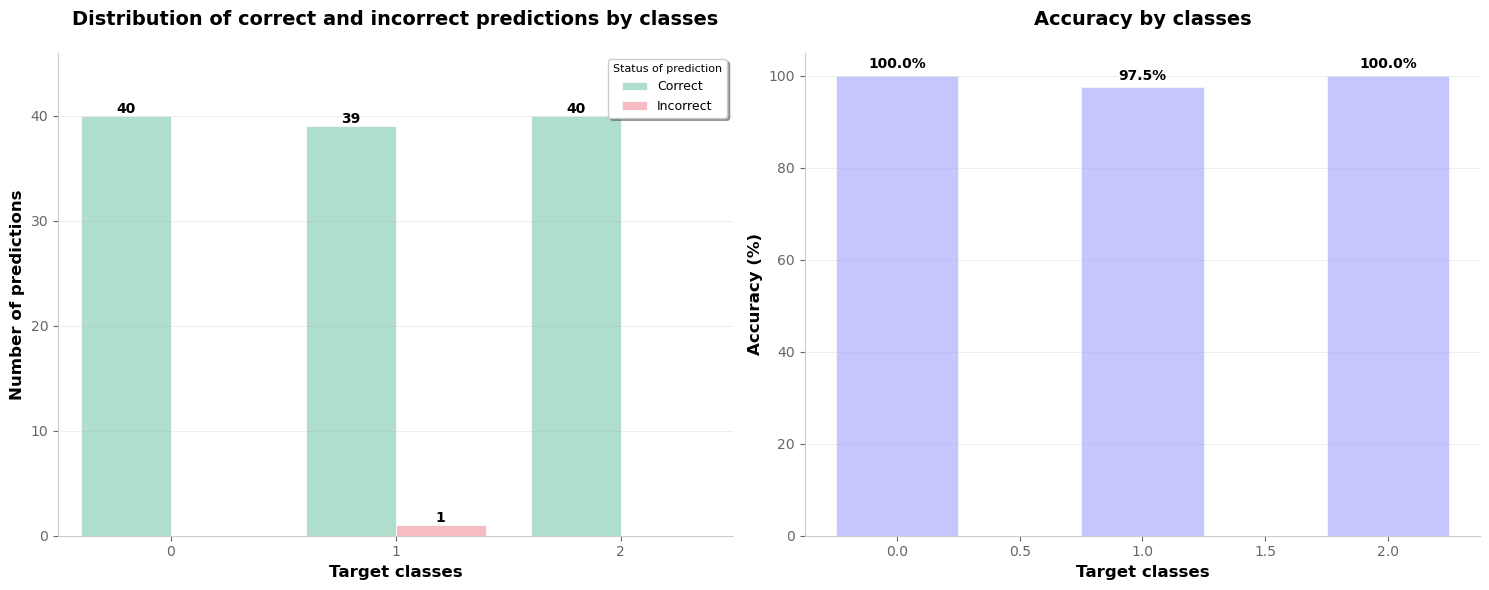

In [328]:
plot_error_distribution(working_train_df_with_predictions['predicted_label'], train_species_labels)


The model demonstrates high classification accuracy on the train set: 100% for class 0, 92.5% for class 1, and 92,5% for class 2. Potential issues: feature overlap with other classes.

##### Distribution of correct and incorrect predictions on test set

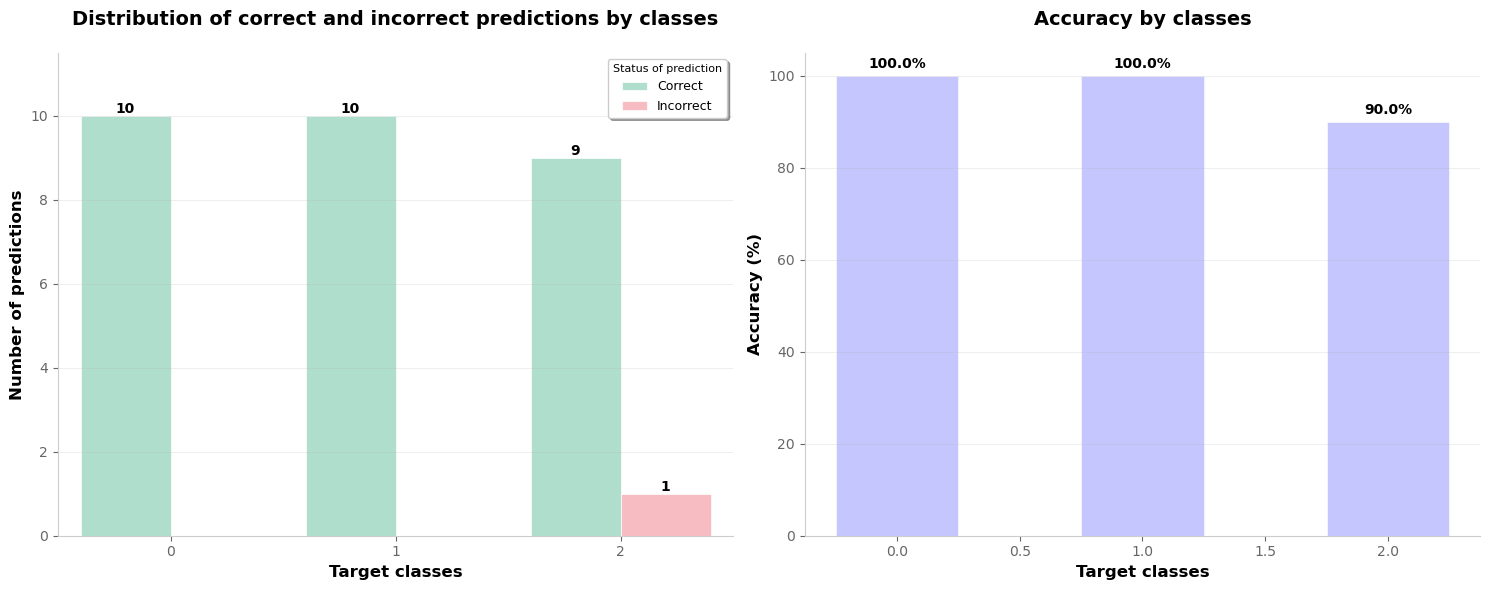

In [329]:
plot_error_distribution(working_test_df_with_predictions['predicted_label'], test_species_labels)

The model demonstrates high classification accuracy on test set: 100% for class 0, 100% for class 1, and 100% for class 2.

##### Create dataframe for error classifications on train set

In [330]:
working_train_df_errors = working_train_df_with_predictions[working_train_df_with_predictions['is_correct'] == False]
working_train_df_errors.iloc[:]

compressed_SepalLengthCm  compressed_SepalWidthCm  \
77                     5.737                    2.577   

    compressed_PetalLengthCm  compressed_PetalWidthCm  compressed_PetalRatio  \
77                       5.0                      1.7               2.863596   

    compressed_SepalRatio  true_label  predicted_label  probability_of_0  \
77               2.011333           1                2               0.0   

    probability_of_1  probability_of_2  is_correct  
77             0.216             0.784       False

##### Create dataframe for error classifications on test set

In [331]:
working_test_df_errors = working_test_df_with_predictions[working_test_df_with_predictions['is_correct'] == False]
working_test_df_errors.head()

compressed_SepalLengthCm  compressed_SepalWidthCm  \
134                     5.917                     2.54   

     compressed_PetalLengthCm  compressed_PetalWidthCm  compressed_PetalRatio  \
134                      5.12                      1.4                    4.0   

     compressed_SepalRatio  true_label  predicted_label  probability_of_0  \
134               2.118262           2                1             0.004   

     probability_of_1  probability_of_2  is_correct  
134             0.653             0.343       False

##### Extract weights and bias from working model 

In [332]:
working_weights = working_model.coef_
working_bias = working_model.intercept_
# working_feature_names = generated_train_measurements.columns.tolist()
working_feature_names = compressed_train_df.drop(columns=['target']).columns.tolist()
print(f"Working\nWeights: {working_weights}\nBias: {working_bias}")

Working
Weights: [[-0.3065067   0.68682737 -1.88077078 -0.74759585  1.3140597  -0.29322609]
 [-0.24284879 -0.69871884 -0.03008076 -0.75918073  0.04408499  0.1791644 ]
 [ 0.54935549  0.01189147  1.91085154  1.50677658 -1.35814469  0.11406169]]
Bias: [ 2.85627749  5.8209115  -8.67718899]


##### Create detailed analysis dataframe by working model 

In [333]:
working_train_detailed_df = create_detailed_analysis(working_train_df_with_predictions, working_weights, working_bias, working_feature_names)
working_test_detailed_df = create_detailed_analysis(working_test_df_with_predictions, working_weights, working_bias, working_feature_names)
working_train_detailed_df.head()

original_idx  true_label  predicted_label  logit_class_0  \
0           123           2                2         -5.019   
1           106           2                2         -4.063   
2           149           2                2         -4.937   
3            10           0                0          7.554   
4            98           1                1         -0.477   

   probability_class_0  bias_class_0  logit_class_1  probability_class_1  \
0                0.000         2.856          1.584                0.136   
1                0.001         2.856          1.918                0.443   
2                0.000         2.856          1.512                0.129   
3                0.992         2.856          2.695                0.008   
4                0.048         2.856          2.509                0.942   

   bias_class_1  logit_class_2  probability_class_2  bias_class_2  \
0         5.821          3.435                0.864        -8.677   
1         5.821          2.145                0.556        -8.677   
2         5.821          3.425                0.871        -8.677   
3         5.821        -10.249                0.000        -8.677   
4         5.821         -2.033                0.010        -8.677   

   compressed_SepalLengthCm_value  \
0                           5.997   
1                           4.900   
2                           5.837   
3                           4.800   
4                           5.097   

   compressed_SepalLengthCm_contribution_class_0  \
0                                         -1.838   
1                                         -1.502   
2                                         -1.789   
3                                         -1.471   
4                                         -1.562   

   compressed_SepalLengthCm_weight_class_0  \
0                                   -0.307   
1                                   -0.307   
2                                   -0.307   
3                                   -0.307   
4                                   -0.307   

   compressed_SepalLengthCm_contribution_class_1  \
0                                         -1.456   
1                                         -1.190   
2                                         -1.418   
3                                         -1.166   
4                                         -1.238   

   compressed_SepalLengthCm_weight_class_1  \
0                                   -0.243   
1                                   -0.243   
2                                   -0.243   
3                                   -0.243   
4                                   -0.243   

   compressed_SepalLengthCm_contribution_class_2  \
0                                          3.294   
1                                          2.692   
2                                          3.207   
3                                          2.637   
4                                          2.800   

   compressed_SepalLengthCm_weight_class_2  compressed_SepalWidthCm_value  \
0                                    0.549                          2.580   
1                                    0.549                          2.500   
2                                    0.549                          2.700   
3                                    0.549                          3.277   
4                                    0.549                          2.377   

   compressed_SepalWidthCm_contribution_class_0  \
0                                         1.772   
1                                         1.717   
2                                         1.854   
3                                         2.251   
4                                         1.633   

   compressed_SepalWidthCm_weight_class_0  \
0                                   0.687   
1                                   0.687   
2                                   0.687   
3                                   0.687   
4                                   0.687

##### Dataframe with missclassifications on train set

In [334]:
working_train_error_df = working_train_detailed_df[working_train_detailed_df['true_label'] != working_train_detailed_df['predicted_label']]
print(list(working_train_error_df.columns))
print(working_train_error_df.shape)
working_train_error_df.head(10)

['original_idx', 'true_label', 'predicted_label', 'logit_class_0', 'probability_class_0', 'bias_class_0', 'logit_class_1', 'probability_class_1', 'bias_class_1', 'logit_class_2', 'probability_class_2', 'bias_class_2', 'compressed_SepalLengthCm_value', 'compressed_SepalLengthCm_contribution_class_0', 'compressed_SepalLengthCm_weight_class_0', 'compressed_SepalLengthCm_contribution_class_1', 'compressed_SepalLengthCm_weight_class_1', 'compressed_SepalLengthCm_contribution_class_2', 'compressed_SepalLengthCm_weight_class_2', 'compressed_SepalWidthCm_value', 'compressed_SepalWidthCm_contribution_class_0', 'compressed_SepalWidthCm_weight_class_0', 'compressed_SepalWidthCm_contribution_class_1', 'compressed_SepalWidthCm_weight_class_1', 'compressed_SepalWidthCm_contribution_class_2', 'compressed_SepalWidthCm_weight_class_2', 'compressed_PetalLengthCm_value', 'compressed_PetalLengthCm_contribution_class_0', 'compressed_PetalLengthCm_weight_class_0', 'compressed_PetalLengthCm_contribution_clas

original_idx  true_label  predicted_label  logit_class_0  \
29            77           1                2         -4.634   

    probability_class_0  bias_class_0  logit_class_1  probability_class_1  \
29                  0.0         2.856          1.673                0.216   

    bias_class_1  logit_class_2  probability_class_2  bias_class_2  \
29         5.821          2.961                0.784        -8.677   

    compressed_SepalLengthCm_value  \
29                           5.737   

    compressed_SepalLengthCm_contribution_class_0  \
29                                         -1.758   

    compressed_SepalLengthCm_weight_class_0  \
29                                   -0.307   

    compressed_SepalLengthCm_contribution_class_1  \
29                                         -1.393   

    compressed_SepalLengthCm_weight_class_1  \
29                                   -0.243   

    compressed_SepalLengthCm_contribution_class_2  \
29                                          3.152   

    compressed_SepalLengthCm_weight_class_2  compressed_SepalWidthCm_value  \
29                                    0.549                          2.577   

    compressed_SepalWidthCm_contribution_class_0  \
29                                          1.77   

    compressed_SepalWidthCm_weight_class_0  \
29                                   0.687   

    compressed_SepalWidthCm_contribution_class_1  \
29                                        -1.801   

    compressed_SepalWidthCm_weight_class_1  \
29                                  -0.699   

    compressed_SepalWidthCm_contribution_class_2  \
29                                         0.031   

    compressed_SepalWidthCm_weight_class_2  compressed_PetalLengthCm_value  \
29                                   0.012                             5.0   

    compressed_PetalLengthCm_contribution_class_0  \
29                                         -9.404   

    compressed_PetalLengthCm_weight_class_0  \
29                                   -1.881   

    compressed_PetalLengthCm_contribution_class_1  \
29                                          -0.15   

    compressed_PetalLengthCm_weight_class_1  \
29                                    -0.03   

    compressed_PetalLengthCm_contribution_class_2  \
29                                          9.554   

    compressed_PetalLengthCm_weight_class_2  compressed_PetalWidthCm_value  \
29                                    1.911                            1.7   

    compressed_PetalWidthCm_contribution_class_0  \
29                                        -1.271   

    compressed_PetalWidthCm_weight_class_0  \
29                                  -0.748   

    compressed_PetalWidthCm_contribution_class_1  \
29                                        -1.291   

    compressed_PetalWidthCm_weight_class_1  \
29                                  -0.759   

    compressed_PetalWidthCm_contribution_class_2  \
29                                         2.562   

    compressed_PetalWidthCm_weight_class_2  compressed_PetalRatio_value  \
29                                   1.507                        2.864   

    compressed_PetalRatio_contribution_class_0  \
29                                       3.763   

    compressed_PetalRatio_weight_class_0  \
29                                 1.314   

    compressed_PetalRatio_contribution_class_1  \
29                                       0.126   

    compressed_PetalRatio_weight_class_1  \
29                                 0.044   

    compressed_PetalRatio_contribution_class_2  \
29                                      -3.889   

    compressed_PetalRatio_weight_class_2  compressed_SepalRatio_value  \
29                                -1.358                        2.011   

    compressed_SepalRatio_contribution_class_0  \
29                                       -0.59   

    compressed_SepalRatio_weight_class_0  \
29                                -0.293   

    compressed_SepalRatio_contribution

##### Dataframe with missclassifications on test set

In [335]:
working_test_error_df = working_test_detailed_df[working_test_detailed_df['true_label'] != working_test_detailed_df['predicted_label']]
print(list(working_test_error_df.columns))
print(working_test_error_df.shape)
working_test_error_df.head()

['original_idx', 'true_label', 'predicted_label', 'logit_class_0', 'probability_class_0', 'bias_class_0', 'logit_class_1', 'probability_class_1', 'bias_class_1', 'logit_class_2', 'probability_class_2', 'bias_class_2', 'compressed_SepalLengthCm_value', 'compressed_SepalLengthCm_contribution_class_0', 'compressed_SepalLengthCm_weight_class_0', 'compressed_SepalLengthCm_contribution_class_1', 'compressed_SepalLengthCm_weight_class_1', 'compressed_SepalLengthCm_contribution_class_2', 'compressed_SepalLengthCm_weight_class_2', 'compressed_SepalWidthCm_value', 'compressed_SepalWidthCm_contribution_class_0', 'compressed_SepalWidthCm_weight_class_0', 'compressed_SepalWidthCm_contribution_class_1', 'compressed_SepalWidthCm_weight_class_1', 'compressed_SepalWidthCm_contribution_class_2', 'compressed_SepalWidthCm_weight_class_2', 'compressed_PetalLengthCm_value', 'compressed_PetalLengthCm_contribution_class_0', 'compressed_PetalLengthCm_weight_class_0', 'compressed_PetalLengthCm_contribution_clas

original_idx  true_label  predicted_label  logit_class_0  \
5           134           2                1         -3.254   

   probability_class_0  bias_class_0  logit_class_1  probability_class_1  \
5                0.004         2.856          1.948                0.653   

   bias_class_1  logit_class_2  probability_class_2  bias_class_2  \
5         5.821          1.306                0.343        -8.677   

   compressed_SepalLengthCm_value  \
5                           5.917   

   compressed_SepalLengthCm_contribution_class_0  \
5                                         -1.814   

   compressed_SepalLengthCm_weight_class_0  \
5                                   -0.307   

   compressed_SepalLengthCm_contribution_class_1  \
5                                         -1.437   

   compressed_SepalLengthCm_weight_class_1  \
5                                   -0.243   

   compressed_SepalLengthCm_contribution_class_2  \
5                                          3.251   

   compressed_SepalLengthCm_weight_class_2  compressed_SepalWidthCm_value  \
5                                    0.549                           2.54   

   compressed_SepalWidthCm_contribution_class_0  \
5                                         1.745   

   compressed_SepalWidthCm_weight_class_0  \
5                                   0.687   

   compressed_SepalWidthCm_contribution_class_1  \
5                                        -1.775   

   compressed_SepalWidthCm_weight_class_1  \
5                                  -0.699   

   compressed_SepalWidthCm_contribution_class_2  \
5                                          0.03   

   compressed_SepalWidthCm_weight_class_2  compressed_PetalLengthCm_value  \
5                                   0.012                            5.12   

   compressed_PetalLengthCm_contribution_class_0  \
5                                          -9.63   

   compressed_PetalLengthCm_weight_class_0  \
5                                   -1.881   

   compressed_PetalLengthCm_contribution_class_1  \
5                                         -0.154   

   compressed_PetalLengthCm_weight_class_1  \
5                                    -0.03   

   compressed_PetalLengthCm_contribution_class_2  \
5                                          9.784   

   compressed_PetalLengthCm_weight_class_2  compressed_PetalWidthCm_value  \
5                                    1.911                            1.4   

   compressed_PetalWidthCm_contribution_class_0  \
5                                        -1.047   

   compressed_PetalWidthCm_weight_class_0  \
5                                  -0.748   

   compressed_PetalWidthCm_contribution_class_1  \
5                                        -1.063   

   compressed_PetalWidthCm_weight_class_1  \
5                                  -0.759   

   compressed_PetalWidthCm_contribution_class_2  \
5                                         2.109   

   compressed_PetalWidthCm_weight_class_2  compressed_PetalRatio_value  \
5                                   1.507                          4.0   

   compressed_PetalRatio_contribution_class_0  \
5                                       5.256   

   compressed_PetalRatio_weight_class_0  \
5                                 1.314   

   compressed_PetalRatio_contribution_class_1  \
5                                       0.176   

   compressed_PetalRatio_weight_class_1  \
5                                 0.044   

   compressed_PetalRatio_contribution_class_2  \
5                                      -5.433   

   compressed_PetalRatio_weight_class_2  compressed_SepalRatio_value  \
5                                -1.358                        2.118   

   compressed_SepalRatio_contribution_class_0  \
5                                      -0.621   

   compressed_SepalRatio_weight_class_0  \
5                                -0.293   

   compressed_SepalRatio_contribution_class_1  \
5                                        0.38   

   compres

##### Train error analysis

In [336]:
results = analyze_classification_errors_simple(
    df=working_train_error_df,
    feature_names=working_feature_names
)

Analyse classification errors
Number of errors: 1

ERROR #1 (ID: 77.0)
True class: 1 -> Predicted class: 2
Feature contributions (sorted by impact):
  compressed_PetalLengthCm: value=5.00, contribution=9.705 
  compressed_SepalLengthCm: value=5.74, contribution=4.545 
  compressed_PetalRatio: value=2.86, contribution=-4.015 
  compressed_PetalWidthCm: value=1.70, contribution=3.852 
  compressed_SepalWidthCm: value=2.58, contribution=1.831 
  compressed_SepalRatio: value=2.01, contribution=-0.131 
Main impact: compressed_PetalLengthCm (contribution: 9.705)


SUMMARY TABLE OF ERRORS:
----------------------------------------------------------------------
Error    ID    True       Predicted     Main impact     Contribution
----------------------------------------------------------------------
error_1  77.0  1          2             compressed_PetalLengthCm 9.705   
----------------------------------------------------------------------


All classification errors were driven by extreme contributions from `generated_PetalLengthCm` == `PetalLengthCm`, indicating the model's over-reliance on this single feature and the limited corrective effect of engineered ratios.

##### Test error analysis

In [337]:
results = analyze_classification_errors_simple(
    df=working_test_error_df,
    feature_names=working_feature_names
)

Analyse classification errors
Number of errors: 1

ERROR #1 (ID: 134.0)
True class: 2 -> Predicted class: 1
Feature contributions (sorted by impact):
  compressed_PetalLengthCm: value=5.12, contribution=-9.938 
  compressed_PetalRatio: value=4.00, contribution=5.609 
  compressed_SepalLengthCm: value=5.92, contribution=-4.687 
  compressed_PetalWidthCm: value=1.40, contribution=-3.172 
  compressed_SepalWidthCm: value=2.54, contribution=-1.805 
  compressed_SepalRatio: value=2.12, contribution=0.138 
Main impact: compressed_PetalLengthCm (contribution: -9.938)


SUMMARY TABLE OF ERRORS:
----------------------------------------------------------------------
Error    ID    True       Predicted     Main impact     Contribution
----------------------------------------------------------------------
error_1  134.0 2          1             compressed_PetalLengthCm -9.938  
----------------------------------------------------------------------


Unfortunately, the applied approach did not yield the desired result; while adding new features based on pairwise relationships helped mitigate the impact of mutants, it did not reduce the dominance of the `PetalLengthCm` feature.


### EDA

##### Create 2 dataframes (train and test) which will contain original target and predicted labels

In [338]:
general_train_df_for_plot = working_train_detailed_df.copy()
general_test_df_for_plot = working_test_detailed_df.copy()

general_train_df_for_plot['true_label'] = general_train_df_for_plot['true_label'].map(target_dict)
general_train_df_for_plot['predicted_label'] = general_train_df_for_plot['predicted_label'].map(target_dict)
general_test_df_for_plot['true_label'] = general_test_df_for_plot['true_label'].map(target_dict)
general_test_df_for_plot['predicted_label'] = general_test_df_for_plot['predicted_label'].map(target_dict)


Visualize distributions of problematic feature (PetalLengthCm) by classes for train set

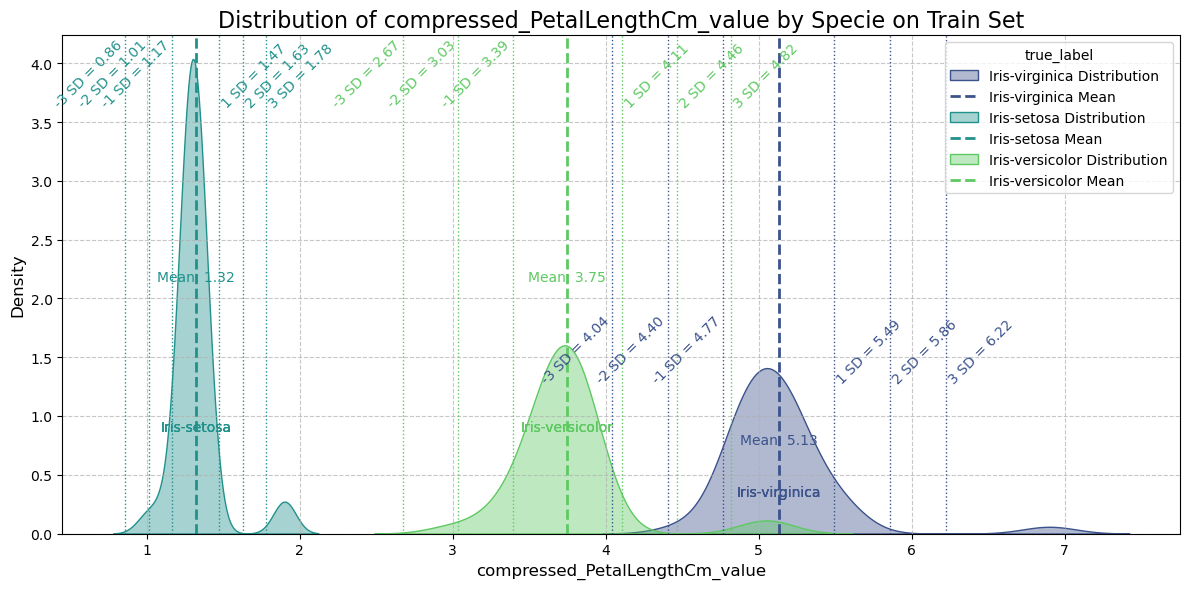

In [339]:
plot_distributions_of_feature_by_classes(
    general_df=general_train_df_for_plot,
    feature_name='compressed_PetalLengthCm_value',
    target_name='true_label', 
    flag='train'
)

The distributions of the problematic feature on train set indicate that the root of the problem lies in the overlapping of the two distributions (Versicolor and Virginica), starting from approximately ±1 standard deviation.


Visualize distributions of problematic feature (PetalLengthCm) by classes for test set

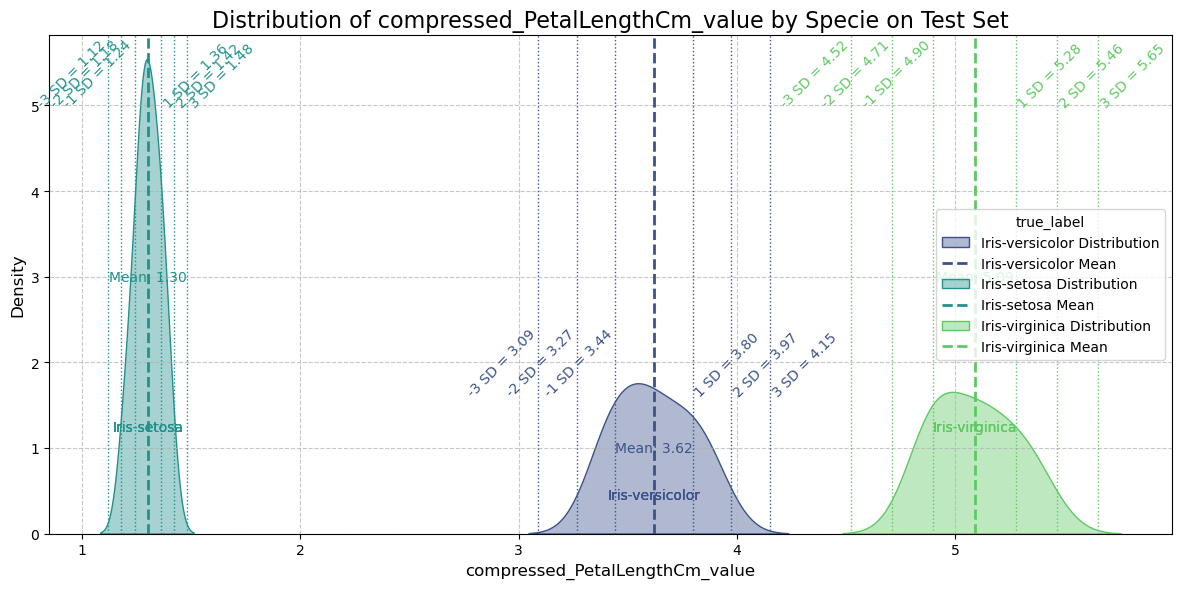

In [340]:
plot_distributions_of_feature_by_classes(
    general_df=general_test_df_for_plot,
    feature_name='compressed_PetalLengthCm_value',
    target_name='true_label',
    flag='test'
)

The distributions of the problematic feature on test set indicate that the root of the problem lies in the overlapping of the two distributions (Versicolor and Virginica), starting from approximately ±1.5 standard deviation.

Visualize distributions of problematic feature (PetalLengthCm) by classes for train set and visualize missclassifications 

/Users/nikolaynechay/Iris-Species/src/core/helpers/visualizations.py:82: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x=target_name, y=feature_name, data=general_df, palette=colors)


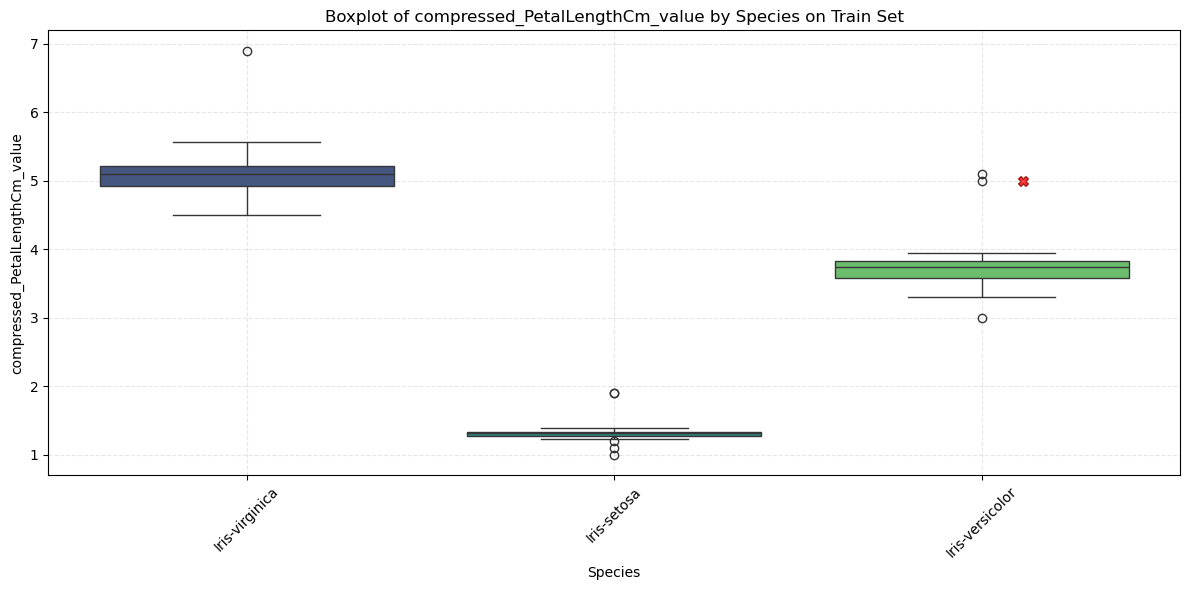

In [341]:
plot_boxplot_with_missclassifications(
    general_df=general_train_df_for_plot,
    feature_name='compressed_PetalLengthCm_value',
    target_name='true_label',
    flag='train'
)

As seen in the graph, all misclassifications occur in the region where the two distributions overlap. This is because the prediction probabilities for the classes at the intersection boundary (within ± 1 standard deviation) are approximately equal, resulting in similar probabilities for both classes. Further out, at the ends of the distributions, the probabilities for each class drop significantly, and in the central region, the separation is almost perfect.

This feature has the highest coefficient in the linear equation, making it the most influential for classification. However, due to the near 50% probabilities for both classes in this overlapping region, we observe misclassifications. Analyzing the class probabilities confirms that they are approximately equal (around 50%).


Visualize distributions of problematic feature (PetalLengthCm) by classes for test set and visualize missclassifications 

/Users/nikolaynechay/Iris-Species/src/core/helpers/visualizations.py:82: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x=target_name, y=feature_name, data=general_df, palette=colors)


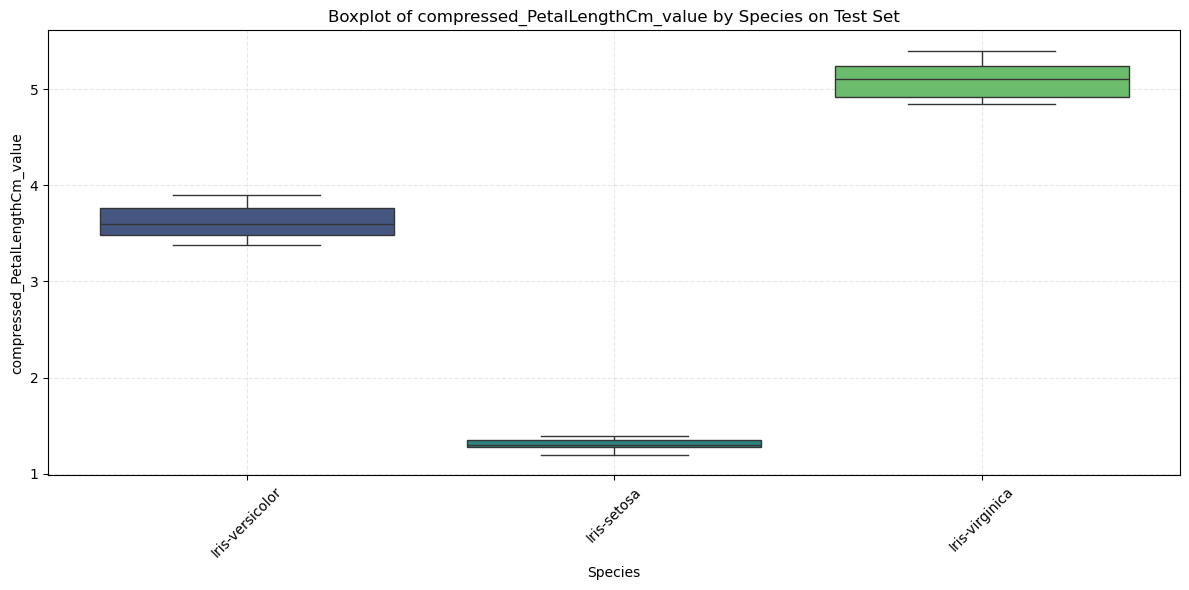

In [342]:
plot_boxplot_with_missclassifications(
    general_df=general_test_df_for_plot,
    feature_name='compressed_PetalLengthCm_value',
    target_name='true_label',
    flag='test'
)

### Feature Engineering

Since all the misclassifications occur under the highest influence of the **PetalLengthCm** feature, and this feature does not provide linear separability between the classes, it might be worth considering removing it from the dataset.

In [343]:
train_features_without_petallength = generated_train_measurements.drop(columns=['PetalLengthCm'])
test_features_without_petallength = generated_test_measurements.drop(columns=['PetalLengthCm'])

# 🧾 Display shapes of all relevant datasets
print("Shape of training labels:", generated_train_species_labels.shape)
print("Shape of training features (without 'PetalLengthCm'):", train_features_without_petallength.shape)

print("Shape of test features (without 'PetalLengthCm'):", test_features_without_petallength.shape)
print("Shape of test labels:", generated_test_species_labels.shape)

print(train_features_without_petallength.head())

Shape of training labels: (120,)
Shape of training features (without 'PetalLengthCm'): (120, 5)
Shape of test features (without 'PetalLengthCm'): (30, 5)
Shape of test labels: (30,)
     SepalLengthCm  SepalWidthCm  PetalWidthCm  PetalRatio  SepalRatio
123            6.3           2.7           1.8    2.722222    2.333333
106            4.9           2.5           1.7    2.647059    1.960000
149            5.9           3.0           1.8    2.833333    1.966667
10             5.4           3.7           0.2    7.500000    1.459459
98             5.1           2.5           1.1    2.727273    2.040000


Current working model is a logistic regression classifier with the following configuration:

- **Regularization**: L2 (Ridge), to penalize large coefficients and reduce overfitting.
- **Optimization algorithm**: LBFGS
- **Max iterations**: 50, to ensure convergence within a reasonable time frame.

### Model building

In [344]:
study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective_for_logistic_regression(
    trial=trial,
    X_train=train_features_without_petallength,
    y_train=generated_train_species_labels,
    X_test=test_features_without_petallength,
    y_test=generated_test_species_labels
), n_trials=50)

best_params = study.best_params
print(f'Best Hyperparameters: {best_params}')

working_model_without_petallength = LogisticRegression(**best_params, random_state=41)
working_model_without_petallength.fit(train_features_without_petallength, generated_train_species_labels)

working_train_without_petallength_df_with_predictions, working_train_without_petallength_accuracy, working_train_without_petallength_precision, working_train_without_petallength_recall, working_train_without_petallength_f1 = evaluate_model(train_features_without_petallength, generated_train_species_labels, working_model_without_petallength)
working_test_without_petallength_df_with_predictions, working_test_without_petallength_accuracy, working_test_without_petallength_precision, working_test_without_petallength_recall, working_test_without_petallength_f1 = evaluate_model(test_features_without_petallength, generated_test_species_labels, working_model_without_petallength)

print("Working model evaluation (without 'PetalLengthCm'):")
print(f"Train Accuracy: {working_train_without_petallength_accuracy:.4f}")
print(f"Train Precision: {working_train_without_petallength_precision:.4f}")
print(f"Train Recall: {working_train_without_petallength_recall:.4f}")
print(f"Train F1: {working_train_without_petallength_f1:.4f}")
print('---------------------')
print(f"Test Accuracy: {working_test_without_petallength_accuracy:.4f}")
print(f"Test Precision: {working_test_without_petallength_precision:.4f}")
print(f"Test Recall: {working_test_without_petallength_recall:.4f}")
print(f"Test F1: {working_test_without_petallength_f1:.4f}")

[I 2025-07-28 20:54:49,356] A new study created in memory with name: no-name-a99188f7-e506-4995-a75a-fba47683ffae
/Users/nikolaynechay/Iris-Species/src/core/helpers/optuna_objective.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-4, 1e2)
/Users/nikolaynechay/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2025-07-28 20:54:49,378] Trial 0 finished with value: 0.8653198653198653 and parameters: {'C': 1.4984567129123063, 'penalty': 'l2', 'class_weight': None, 'max_iter': 101, 'solver': 'saga'}. Best is trial 0 with value: 0.8653198653198653.
/Users/nikolaynechay/Iris-Species/src/core/helpers/optuna_objective.py:31: FutureWarning: suggest_loguniform has been depre

Best Hyperparameters: {'C': 8.849371201988966, 'penalty': 'l2', 'class_weight': None, 'max_iter': 652, 'solver': 'liblinear'}
Working model evaluation (without 'PetalLengthCm'):
Train Accuracy: 0.9583
Train Precision: 0.9589
Train Recall: 0.9583
Train F1: 0.9585
---------------------
Test Accuracy: 0.9000
Test Precision: 0.9024
Test Recall: 0.9000
Test F1: 0.8997


In [345]:
working_train_without_petallength_df_with_predictions.head()

SepalLengthCm  SepalWidthCm  PetalWidthCm  PetalRatio  SepalRatio  \
123            6.3           2.7           1.8    2.722222    2.333333   
106            4.9           2.5           1.7    2.647059    1.960000   
149            5.9           3.0           1.8    2.833333    1.966667   
10             5.4           3.7           0.2    7.500000    1.459459   
98             5.1           2.5           1.1    2.727273    2.040000   

     true_label  predicted_label  probability_of_0  probability_of_1  \
123           2                2             0.000             0.367   
106           2                2             0.003             0.250   
149           2                2             0.002             0.189   
10            0                0             0.992             0.008   
98            1                1             0.016             0.945   

     probability_of_2  is_correct  
123             0.633        True  
106             0.747        True  
149             0.809        True  
10              0.000        True  
98              0.039        True

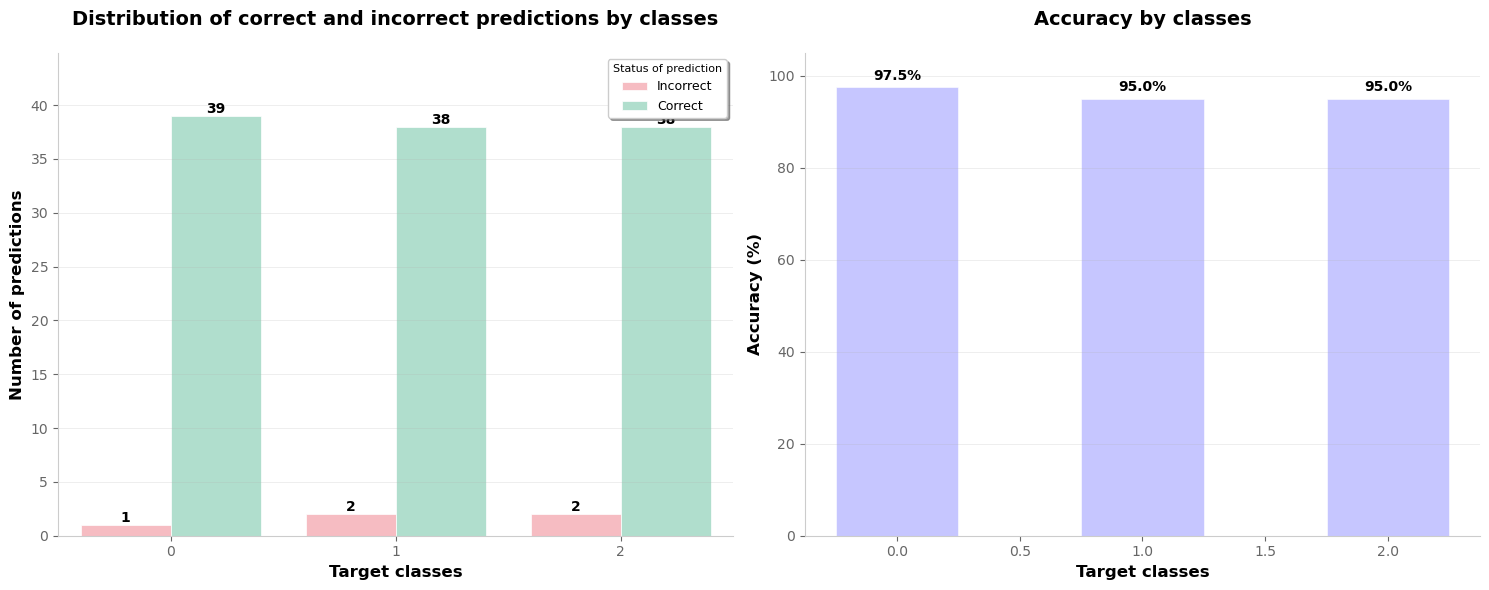

In [346]:
plot_error_distribution(working_train_without_petallength_df_with_predictions['predicted_label'], generated_train_species_labels)

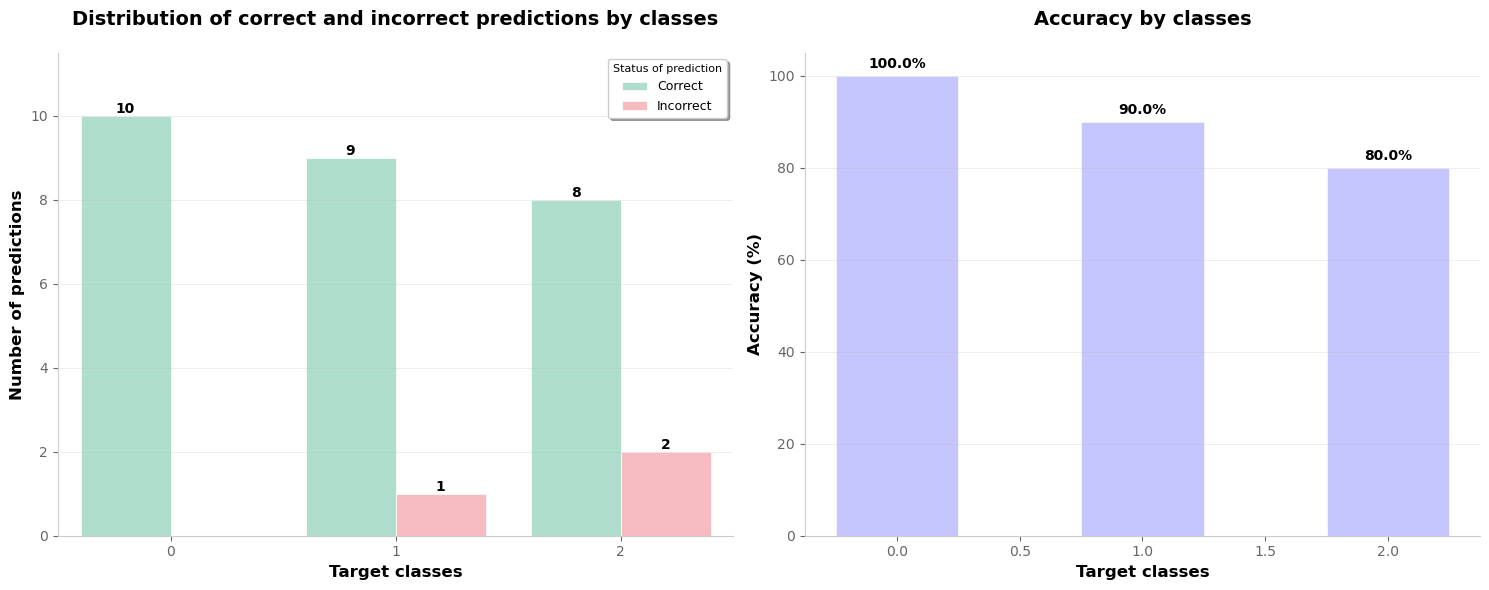

In [347]:
plot_error_distribution(working_test_without_petallength_df_with_predictions['predicted_label'], generated_test_species_labels)

In [348]:
working_train_df_without_petallength_errors = working_train_without_petallength_df_with_predictions[working_train_without_petallength_df_with_predictions['is_correct'] == False]
working_train_df_without_petallength_errors.iloc[:]

SepalLengthCm  SepalWidthCm  PetalWidthCm  PetalRatio  SepalRatio  \
77             6.7           3.0           1.7    2.941176    2.233333   
41             4.5           2.3           0.3    4.333333    1.956522   
85             6.0           3.4           1.6    2.812500    1.764706   
129            7.2           3.0           1.6    3.625000    2.400000   
119            6.0           2.2           1.5    3.333333    2.727273   

     true_label  predicted_label  probability_of_0  probability_of_1  \
77            1                2             0.000             0.424   
41            0                1             0.495             0.505   
85            1                2             0.029             0.424   
129           2                1             0.001             0.729   
119           2                1             0.000             0.727   

     probability_of_2  is_correct  
77              0.575       False  
41              0.000       False  
85              0.547       False  
129             0.270       False  
119             0.273       False

In [349]:
working_test_df_without_petallength_errors = working_test_without_petallength_df_with_predictions[working_test_without_petallength_df_with_predictions['is_correct'] == False]
working_test_df_without_petallength_errors.head()

SepalLengthCm  SepalWidthCm  PetalWidthCm  PetalRatio  SepalRatio  \
134            6.1           2.6           1.4    4.000000    2.346154   
70             5.9           3.2           1.8    2.666667    1.843750   
133            6.3           2.8           1.5    3.400000    2.250000   

     true_label  predicted_label  probability_of_0  probability_of_1  \
134           2                1             0.013             0.940   
70            1                2             0.003             0.160   
133           2                1             0.004             0.784   

     probability_of_2  is_correct  
134             0.048       False  
70              0.836       False  
133             0.212       False

In [350]:
working_weights_without_petallength = working_model_without_petallength.coef_
working_bias_without_petallength = working_model_without_petallength.intercept_
working_feature_names = train_features_without_petallength.columns.tolist()

print(f"Working\nWeights: {working_weights_without_petallength}\nBias: {working_bias_without_petallength}")

Working
Weights: [[-1.75641265  2.73604949 -3.29282023  1.61199271 -1.57935569]
 [ 0.67454036 -0.97204801 -3.99050531 -1.5747751   2.5569933 ]
 [ 0.97820359 -2.70233723  7.25312828 -2.45549458 -0.7673471 ]]
Bias: [ 0.30659589  3.953408   -1.31709725]


In [351]:
working_train_detailed_df_without_petallength= create_detailed_analysis(working_train_df_without_petallength_errors, working_weights_without_petallength, working_bias_without_petallength, working_feature_names)
working_test_detailed_df_without_petallength = create_detailed_analysis(working_test_df_without_petallength_errors, working_weights_without_petallength, working_bias_without_petallength, working_feature_names)
working_train_detailed_df_without_petallength.head()

original_idx  true_label  predicted_label  logit_class_0  \
0            77           1                2         -7.637   
1            41           0                1          1.603   
2            85           1                2         -4.451   
3           129           2                1         -7.347   
4           119           2                1         -8.086   

   probability_class_0  bias_class_0  logit_class_1  probability_class_1  \
0                0.000         0.307         -0.148                0.338   
1                0.467         0.307          1.735                0.533   
2                0.024         0.307         -1.606                0.412   
3                0.001         0.307         -0.063                0.811   
4                0.000         0.307          1.601                0.916   

   bias_class_1  logit_class_2  probability_class_2  bias_class_2  \
0         3.953          0.524                0.662        -1.317   
1         3.953        -13.096                0.000        -1.317   
2         3.953         -1.291                0.564        -1.317   
3         3.953         -1.519                0.189        -1.317   
4         3.953         -0.791                0.084        -1.317   

   SepalLengthCm_value  SepalLengthCm_contribution_class_0  \
0                  6.7                             -11.768   
1                  4.5                              -7.904   
2                  6.0                             -10.538   
3                  7.2                             -12.646   
4                  6.0                             -10.538   

   SepalLengthCm_weight_class_0  SepalLengthCm_contribution_class_1  \
0                        -1.756                               4.519   
1                        -1.756                               3.035   
2                        -1.756                               4.047   
3                        -1.756                               4.857   
4                        -1.756                               4.047   

   SepalLengthCm_weight_class_1  SepalLengthCm_contribution_class_2  \
0                         0.675                               6.554   
1                         0.675                               4.402   
2                         0.675                               5.869   
3                         0.675                               7.043   
4                         0.675                               5.869   

   SepalLengthCm_weight_class_2  SepalWidthCm_value  \
0                         0.978                 3.0   
1                         0.978                 2.3   
2                         0.978                 3.4   
3                         0.978                 3.0   
4                         0.978                 2.2   

   SepalWidthCm_contribution_class_0  SepalWidthCm_weight_class_0  \
0                              8.208                        2.736   
1                              6.293                        2.736   
2                              9.303                        2.736   
3                              8.208                        2.736   
4                              6.019                        2.736   

   SepalWidthCm_contribution_class_1  SepalWidthCm_weight_class_1  \
0                             -2.916                       -0.972   
1                             -2.236                       -0.972   
2                             -3.305                       -0.972   
3                             -2.916                       -0.972   
4                             -2.139                       -0.972   

   SepalWidthCm_contribution_class_2  SepalWidthCm_weight_class_2  \
0                             -8.107                       -2.702   
1                             -6.215                       -2.702   
2                             -9.188                       -2.702   
3                             -8.107                       -2.702   
4                  

In [352]:
working_train_error_df_without_petallength = working_train_detailed_df_without_petallength[working_train_detailed_df_without_petallength['true_label'] != working_train_detailed_df_without_petallength['predicted_label']]
print(list(working_train_error_df_without_petallength.columns))
print(working_train_error_df_without_petallength.shape)
working_train_error_df_without_petallength.head(10)

['original_idx', 'true_label', 'predicted_label', 'logit_class_0', 'probability_class_0', 'bias_class_0', 'logit_class_1', 'probability_class_1', 'bias_class_1', 'logit_class_2', 'probability_class_2', 'bias_class_2', 'SepalLengthCm_value', 'SepalLengthCm_contribution_class_0', 'SepalLengthCm_weight_class_0', 'SepalLengthCm_contribution_class_1', 'SepalLengthCm_weight_class_1', 'SepalLengthCm_contribution_class_2', 'SepalLengthCm_weight_class_2', 'SepalWidthCm_value', 'SepalWidthCm_contribution_class_0', 'SepalWidthCm_weight_class_0', 'SepalWidthCm_contribution_class_1', 'SepalWidthCm_weight_class_1', 'SepalWidthCm_contribution_class_2', 'SepalWidthCm_weight_class_2', 'PetalWidthCm_value', 'PetalWidthCm_contribution_class_0', 'PetalWidthCm_weight_class_0', 'PetalWidthCm_contribution_class_1', 'PetalWidthCm_weight_class_1', 'PetalWidthCm_contribution_class_2', 'PetalWidthCm_weight_class_2', 'PetalRatio_value', 'PetalRatio_contribution_class_0', 'PetalRatio_weight_class_0', 'PetalRatio_c

original_idx  true_label  predicted_label  logit_class_0  \
0            77           1                2         -7.637   
1            41           0                1          1.603   
2            85           1                2         -4.451   
3           129           2                1         -7.347   
4           119           2                1         -8.086   

   probability_class_0  bias_class_0  logit_class_1  probability_class_1  \
0                0.000         0.307         -0.148                0.338   
1                0.467         0.307          1.735                0.533   
2                0.024         0.307         -1.606                0.412   
3                0.001         0.307         -0.063                0.811   
4                0.000         0.307          1.601                0.916   

   bias_class_1  logit_class_2  probability_class_2  bias_class_2  \
0         3.953          0.524                0.662        -1.317   
1         3.953        -13.096                0.000        -1.317   
2         3.953         -1.291                0.564        -1.317   
3         3.953         -1.519                0.189        -1.317   
4         3.953         -0.791                0.084        -1.317   

   SepalLengthCm_value  SepalLengthCm_contribution_class_0  \
0                  6.7                             -11.768   
1                  4.5                              -7.904   
2                  6.0                             -10.538   
3                  7.2                             -12.646   
4                  6.0                             -10.538   

   SepalLengthCm_weight_class_0  SepalLengthCm_contribution_class_1  \
0                        -1.756                               4.519   
1                        -1.756                               3.035   
2                        -1.756                               4.047   
3                        -1.756                               4.857   
4                        -1.756                               4.047   

   SepalLengthCm_weight_class_1  SepalLengthCm_contribution_class_2  \
0                         0.675                               6.554   
1                         0.675                               4.402   
2                         0.675                               5.869   
3                         0.675                               7.043   
4                         0.675                               5.869   

   SepalLengthCm_weight_class_2  SepalWidthCm_value  \
0                         0.978                 3.0   
1                         0.978                 2.3   
2                         0.978                 3.4   
3                         0.978                 3.0   
4                         0.978                 2.2   

   SepalWidthCm_contribution_class_0  SepalWidthCm_weight_class_0  \
0                              8.208                        2.736   
1                              6.293                        2.736   
2                              9.303                        2.736   
3                              8.208                        2.736   
4                              6.019                        2.736   

   SepalWidthCm_contribution_class_1  SepalWidthCm_weight_class_1  \
0                             -2.916                       -0.972   
1                             -2.236                       -0.972   
2                             -3.305                       -0.972   
3                             -2.916                       -0.972   
4                             -2.139                       -0.972   

   SepalWidthCm_contribution_class_2  SepalWidthCm_weight_class_2  \
0                             -8.107                       -2.702   
1                             -6.215                       -2.702   
2                             -9.188                       -2.702   
3                             -8.107                       -2.702   
4                  

In [353]:
working_test_error_df_without_petallength = working_test_detailed_df_without_petallength[working_test_detailed_df_without_petallength['true_label'] != working_test_detailed_df_without_petallength['predicted_label']]
print(list(working_test_error_df_without_petallength.columns))
print(working_test_error_df_without_petallength.shape)
working_test_error_df_without_petallength.head()

['original_idx', 'true_label', 'predicted_label', 'logit_class_0', 'probability_class_0', 'bias_class_0', 'logit_class_1', 'probability_class_1', 'bias_class_1', 'logit_class_2', 'probability_class_2', 'bias_class_2', 'SepalLengthCm_value', 'SepalLengthCm_contribution_class_0', 'SepalLengthCm_weight_class_0', 'SepalLengthCm_contribution_class_1', 'SepalLengthCm_weight_class_1', 'SepalLengthCm_contribution_class_2', 'SepalLengthCm_weight_class_2', 'SepalWidthCm_value', 'SepalWidthCm_contribution_class_0', 'SepalWidthCm_weight_class_0', 'SepalWidthCm_contribution_class_1', 'SepalWidthCm_weight_class_1', 'SepalWidthCm_contribution_class_2', 'SepalWidthCm_weight_class_2', 'PetalWidthCm_value', 'PetalWidthCm_contribution_class_0', 'PetalWidthCm_weight_class_0', 'PetalWidthCm_contribution_class_1', 'PetalWidthCm_weight_class_1', 'PetalWidthCm_contribution_class_2', 'PetalWidthCm_weight_class_2', 'PetalRatio_value', 'PetalRatio_contribution_class_0', 'PetalRatio_weight_class_0', 'PetalRatio_c

original_idx  true_label  predicted_label  logit_class_0  \
0           134           2                1         -5.161   
1            70           1                2         -5.841   
2           133           2                1         -6.110   

   probability_class_0  bias_class_0  logit_class_1  probability_class_1  \
0                0.008         0.307         -0.346                0.963   
1                0.001         0.307         -1.845                0.060   
2                0.002         0.307         -0.105                0.858   

   bias_class_1  logit_class_2  probability_class_2  bias_class_2  \
0         3.953         -3.844                0.029        -1.317   
1         3.953          0.900                0.939        -1.317   
2         3.953         -1.916                0.140        -1.317   

   SepalLengthCm_value  SepalLengthCm_contribution_class_0  \
0                  6.1                             -10.714   
1                  5.9                             -10.363   
2                  6.3                             -11.065   

   SepalLengthCm_weight_class_0  SepalLengthCm_contribution_class_1  \
0                        -1.756                               4.115   
1                        -1.756                               3.980   
2                        -1.756                               4.250   

   SepalLengthCm_weight_class_1  SepalLengthCm_contribution_class_2  \
0                         0.675                               5.967   
1                         0.675                               5.771   
2                         0.675                               6.163   

   SepalLengthCm_weight_class_2  SepalWidthCm_value  \
0                         0.978                 2.6   
1                         0.978                 3.2   
2                         0.978                 2.8   

   SepalWidthCm_contribution_class_0  SepalWidthCm_weight_class_0  \
0                              7.114                        2.736   
1                              8.755                        2.736   
2                              7.661                        2.736   

   SepalWidthCm_contribution_class_1  SepalWidthCm_weight_class_1  \
0                             -2.527                       -0.972   
1                             -3.111                       -0.972   
2                             -2.722                       -0.972   

   SepalWidthCm_contribution_class_2  SepalWidthCm_weight_class_2  \
0                             -7.026                       -2.702   
1                             -8.647                       -2.702   
2                             -7.567                       -2.702   

   PetalWidthCm_value  PetalWidthCm_contribution_class_0  \
0                 1.4                             -4.610   
1                 1.8                             -5.927   
2                 1.5                             -4.939   

   PetalWidthCm_weight_class_0  PetalWidthCm_contribution_class_1  \
0                       -3.293                             -5.587   
1                       -3.293                             -7.183   
2                       -3.293                             -5.986   

   PetalWidthCm_weight_class_1  PetalWidthCm_contribution_class_2  \
0                       -3.991                             10.154   
1                       -3.991                             13.056   
2                       -3.991                             10.880   

   PetalWidthCm_weight_class_2  PetalRatio_value  \
0                        7.253             4.000   
1                        7.253             2.667   
2                        7.253             3.400   

   PetalRatio_contribution_class_0  PetalRatio_weight_class_0  \
0                            6.448                      1.612   
1                            4.299                      1.612   
2                            5.481                      1.612   

   PetalRatio_contribution_class

In [354]:
results = analyze_classification_errors_simple(
    df=working_train_error_df_without_petallength,
    feature_names=train_features_without_petallength.columns.tolist()
)

Analyse classification errors
Number of errors: 5

ERROR #1 (ID: 77.0)
True class: 1 -> Predicted class: 2
Feature contributions (sorted by impact):
  PetalWidthCm   : value=1.70, contribution=19.114 
  SepalRatio     : value=2.23, contribution=-7.424 
  SepalWidthCm   : value=3.00, contribution=-5.191 
  PetalRatio     : value=2.94, contribution=-2.590 
  SepalLengthCm  : value=6.70, contribution=2.035 
Main impact: PetalWidthCm (contribution: 19.114)

ERROR #2 (ID: 41.0)
True class: 0 -> Predicted class: 1
Feature contributions (sorted by impact):
  PetalRatio     : value=4.33, contribution=-13.809 
  SepalLengthCm  : value=4.50, contribution=10.939 
  SepalWidthCm   : value=2.30, contribution=-8.529 
  SepalRatio     : value=1.96, contribution=8.093 
  PetalWidthCm   : value=0.30, contribution=-0.209 
Main impact: PetalRatio (contribution: -13.809)

ERROR #3 (ID: 85.0)
True class: 1 -> Predicted class: 2
Feature contributions (sorted by impact):
  PetalWidthCm   : value=1.60, contri

In [355]:
results = analyze_classification_errors_simple(
    df=working_test_error_df_without_petallength,
    feature_names=test_features_without_petallength.columns.tolist()
)

Analyse classification errors
Number of errors: 3

ERROR #1 (ID: 134.0)
True class: 2 -> Predicted class: 1
Feature contributions (sorted by impact):
  PetalWidthCm   : value=1.40, contribution=-15.741 
  SepalRatio     : value=2.35, contribution=7.799 
  SepalWidthCm   : value=2.60, contribution=4.499 
  PetalRatio     : value=4.00, contribution=3.523 
  SepalLengthCm  : value=6.10, contribution=-1.852 
Main impact: PetalWidthCm (contribution: -15.741)

ERROR #2 (ID: 70.0)
True class: 1 -> Predicted class: 2
Feature contributions (sorted by impact):
  PetalWidthCm   : value=1.80, contribution=20.239 
  SepalRatio     : value=1.84, contribution=-6.129 
  SepalWidthCm   : value=3.20, contribution=-5.537 
  PetalRatio     : value=2.67, contribution=-2.349 
  SepalLengthCm  : value=5.90, contribution=1.792 
Main impact: PetalWidthCm (contribution: 20.239)

ERROR #3 (ID: 133.0)
True class: 2 -> Predicted class: 1
Feature contributions (sorted by impact):
  PetalWidthCm   : value=1.50, cont

### EDA

Create train and test dataframes for comfortable visualization

In [356]:
working_train_detailed_df_without_petallength_for_plot = working_train_without_petallength_df_with_predictions.copy()
working_test_detailed_df_without_petallength_for_plot = working_test_without_petallength_df_with_predictions.copy()

working_train_detailed_df_without_petallength_for_plot['true_label'] = working_train_detailed_df_without_petallength_for_plot['true_label'].map(target_dict)
working_train_detailed_df_without_petallength_for_plot['predicted_label'] = working_train_detailed_df_without_petallength_for_plot['predicted_label'].map(target_dict)
working_test_detailed_df_without_petallength_for_plot['true_label'] = working_test_detailed_df_without_petallength_for_plot['true_label'].map(target_dict)
working_test_detailed_df_without_petallength_for_plot['predicted_label'] = working_test_detailed_df_without_petallength_for_plot['predicted_label'].map(target_dict)

Analyse distribution of feature PetalRatio by classes on train set before compression

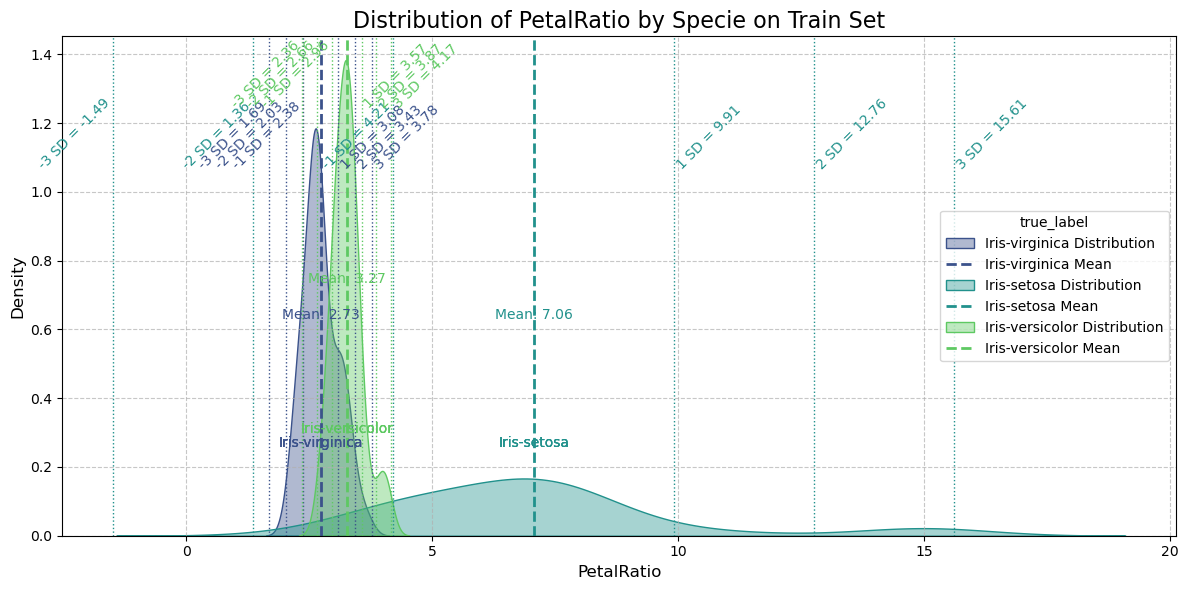

In [357]:
plot_distributions_of_feature_by_classes(
    general_df=working_train_detailed_df_without_petallength_for_plot,
    feature_name='PetalRatio',
    target_name='true_label', 
    flag='train'
)

Analyse distribution of feature PetalRatio by classes on test set before compression

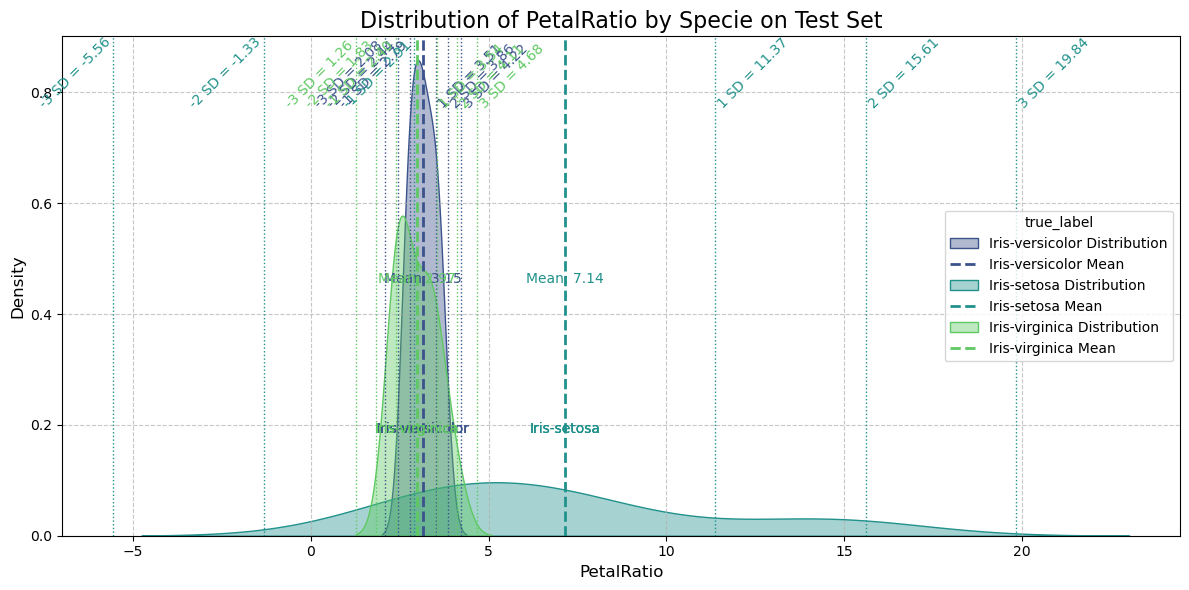

In [358]:
plot_distributions_of_feature_by_classes(
    general_df=working_test_detailed_df_without_petallength_for_plot,
    feature_name='PetalRatio',
    target_name='true_label', 
    flag='test'
)

Visualize distributions of problematic feature (PetalRatio) by classes for train set and visualize missclassifications 

/Users/nikolaynechay/Iris-Species/src/core/helpers/visualizations.py:82: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x=target_name, y=feature_name, data=general_df, palette=colors)


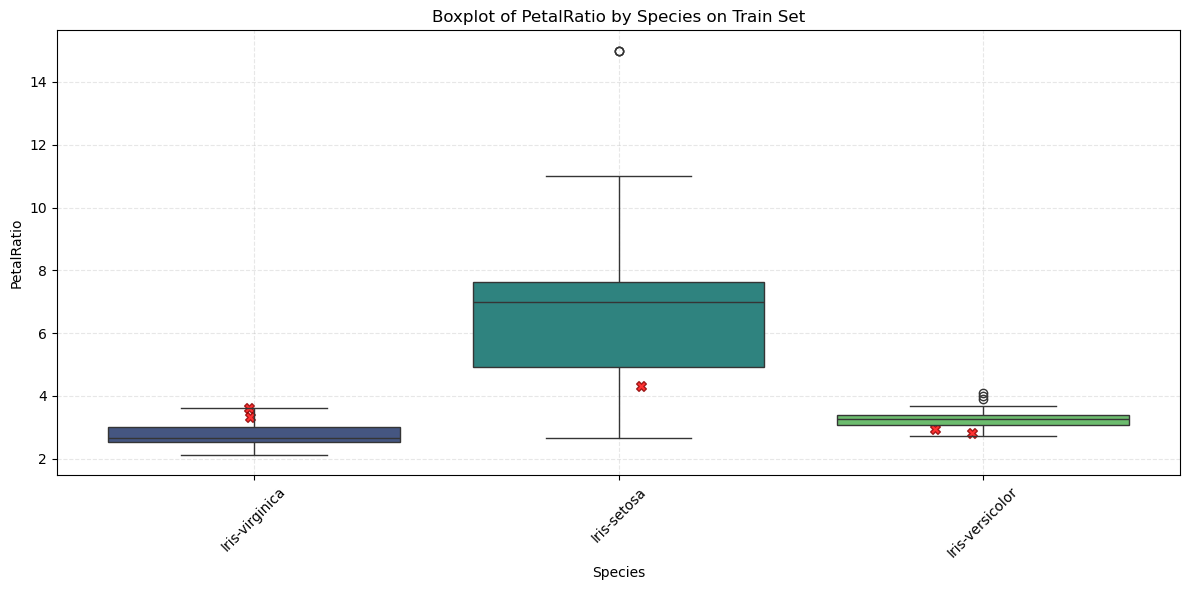

In [359]:
plot_boxplot_with_missclassifications(
    general_df=working_train_detailed_df_without_petallength_for_plot,
    feature_name='PetalRatio',
    target_name='true_label',
    flag='train'
)

Visualize distributions of problematic feature (PetalRatio) by classes for test set and visualize missclassifications 

/Users/nikolaynechay/Iris-Species/src/core/helpers/visualizations.py:82: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x=target_name, y=feature_name, data=general_df, palette=colors)


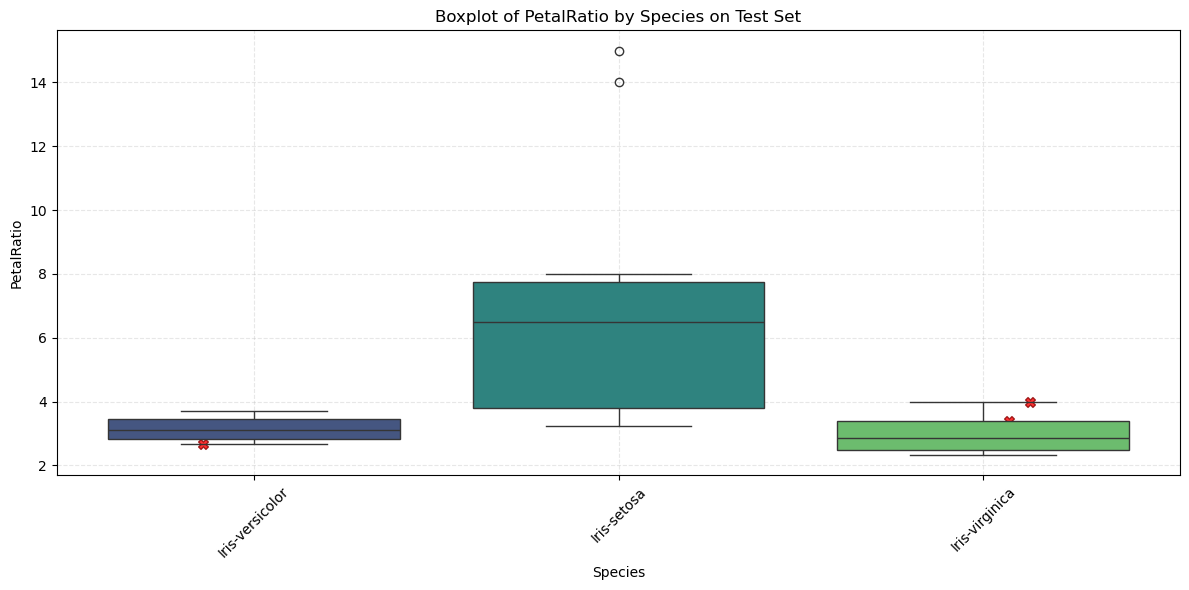

In [360]:
plot_boxplot_with_missclassifications(
    general_df=working_test_detailed_df_without_petallength_for_plot,
    feature_name='PetalRatio',
    target_name='true_label',
    flag='test'
)

Analyse distribution of feature PetalWidthCm by classes on train set before compression

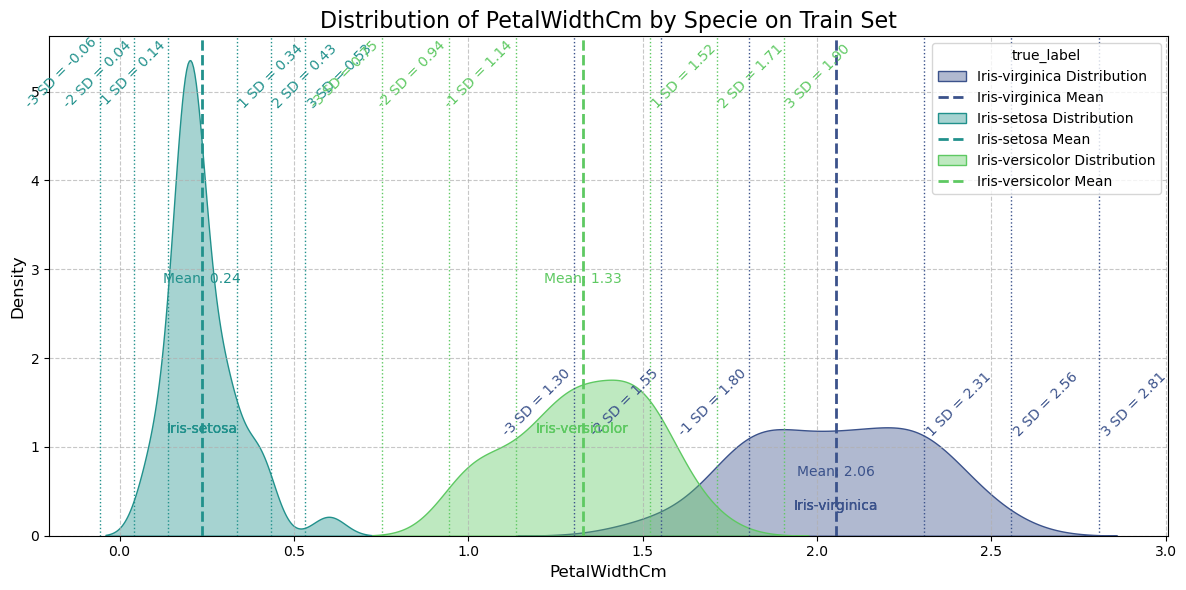

In [361]:
plot_distributions_of_feature_by_classes(
    general_df=working_train_detailed_df_without_petallength_for_plot,
    feature_name='PetalWidthCm',
    target_name='true_label', 
    flag='train'
)

Analyse distribution of feature PetalWidthCm by classes on test set before compression

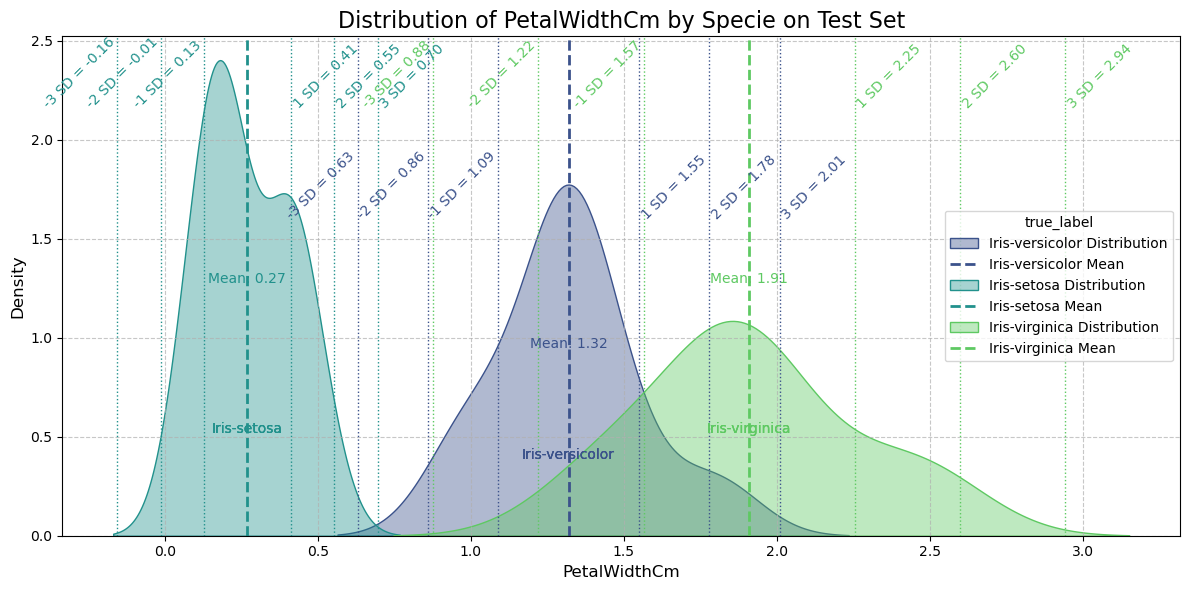

In [362]:
plot_distributions_of_feature_by_classes(
    general_df=working_test_detailed_df_without_petallength_for_plot,
    feature_name='PetalWidthCm',
    target_name='true_label', 
    flag='test'
)

Visualize distributions of problematic feature (PetalWidthCm) by classes for train set and visualize missclassifications 

/Users/nikolaynechay/Iris-Species/src/core/helpers/visualizations.py:82: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x=target_name, y=feature_name, data=general_df, palette=colors)


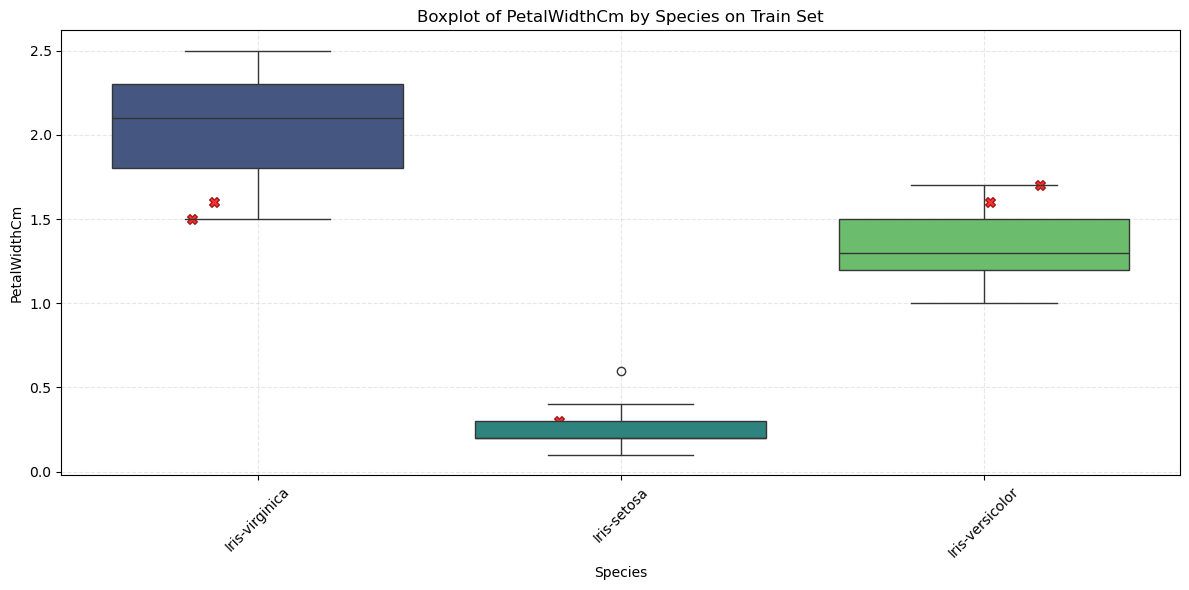

In [363]:
plot_boxplot_with_missclassifications(
    general_df=working_train_detailed_df_without_petallength_for_plot,
    feature_name='PetalWidthCm',
    target_name='true_label',
    flag='train'
)

Visualize distributions of problematic feature (PetalWidthCm) by classes for test set and visualize missclassifications 

/Users/nikolaynechay/Iris-Species/src/core/helpers/visualizations.py:82: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x=target_name, y=feature_name, data=general_df, palette=colors)


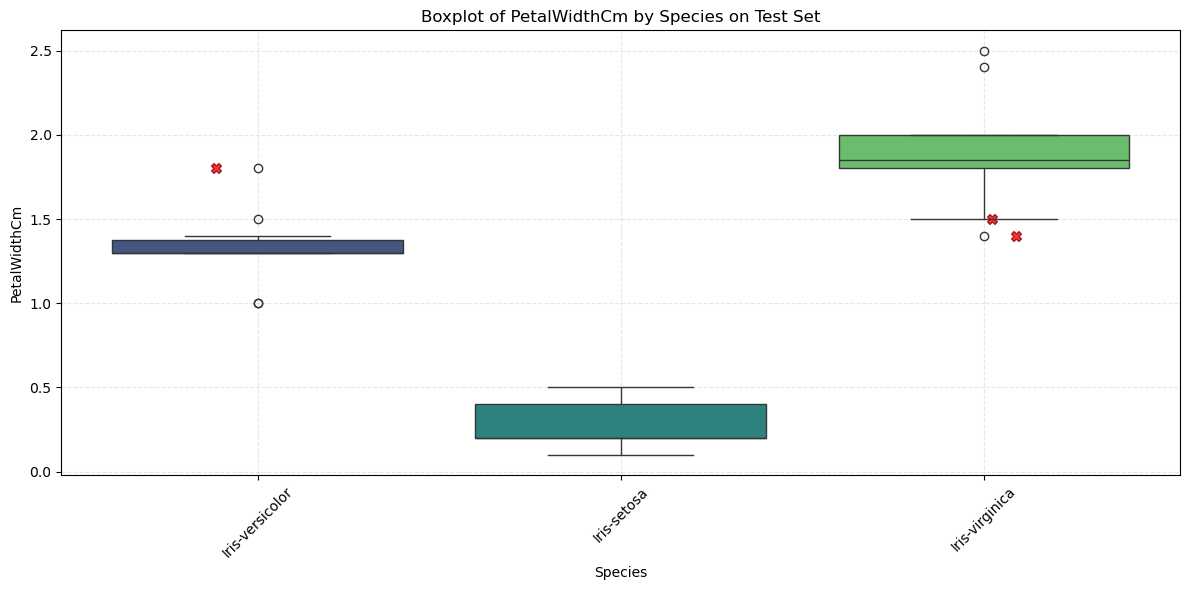

In [364]:
plot_boxplot_with_missclassifications(
    general_df=working_test_detailed_df_without_petallength_for_plot,
    feature_name='PetalWidthCm',
    target_name='true_label',
    flag='test'
)

### Feature Engineering 

Compressing features set by classes to expand space between distributions and improve linear separability on train and test sets

In [365]:
compressed_train_df, compressed_test_df= compress_boundaries_by_class(
    train_df=pd.concat([train_features_without_petallength, generated_train_species_labels], axis=1),
    test_df=pd.concat([test_features_without_petallength, generated_test_species_labels], axis=1),
    feature_names=['PetalRatio', 'PetalWidthCm'],
    true_label_col='target',
    compression_factor=0.4,
    quantile_lower=0.05,
    quantile_upper=0.95
)

compressed_train_df.head()

SepalLengthCm  SepalWidthCm  SepalRatio  target  compressed_PetalRatio  \
123            6.3           2.7    2.333333       2               2.444106   
106            4.9           2.5    1.960000       2               2.414041   
149            5.9           3.0    1.966667       2               2.488551   
10             5.4           3.7    1.459459       0               5.250000   
98             5.1           2.5    2.040000       1               2.727273   

     compressed_PetalWidthCm  
123                    1.737  
106                    1.697  
149                    1.737  
10                     0.140  
98                     1.040

Analyse distribution of feature PetalRatio by classes on train set after compression

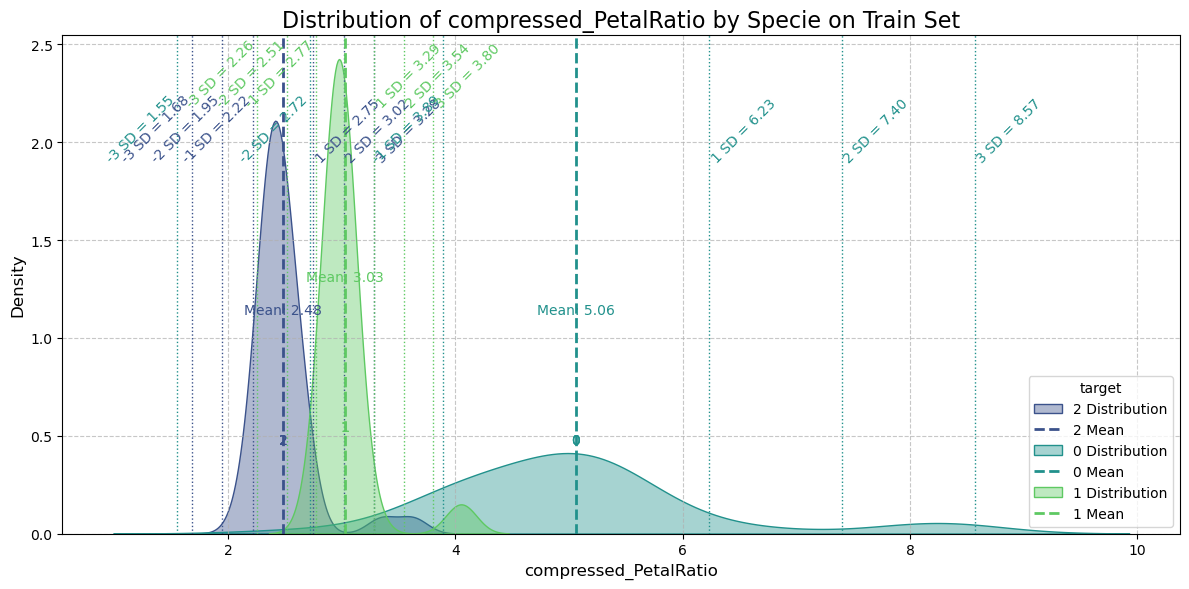

In [366]:
plot_distributions_of_feature_by_classes(
    general_df=compressed_train_df,
    feature_name='compressed_PetalRatio',
    target_name='target', 
    flag='train'
)

Analyse distribution of feature PetalRatio by classes on test set after compression

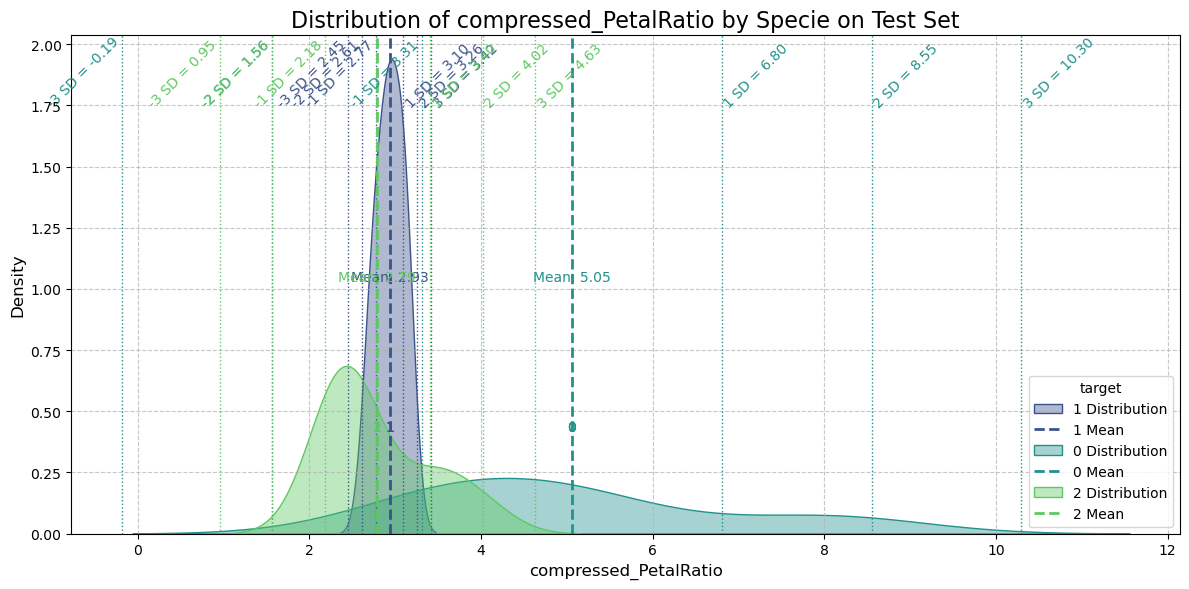

In [367]:
plot_distributions_of_feature_by_classes(
    general_df=compressed_test_df,
    feature_name='compressed_PetalRatio',
    target_name='target', 
    flag='test'
)

Analyse distribution of feature PetalWidthCm by classes on train set after compression

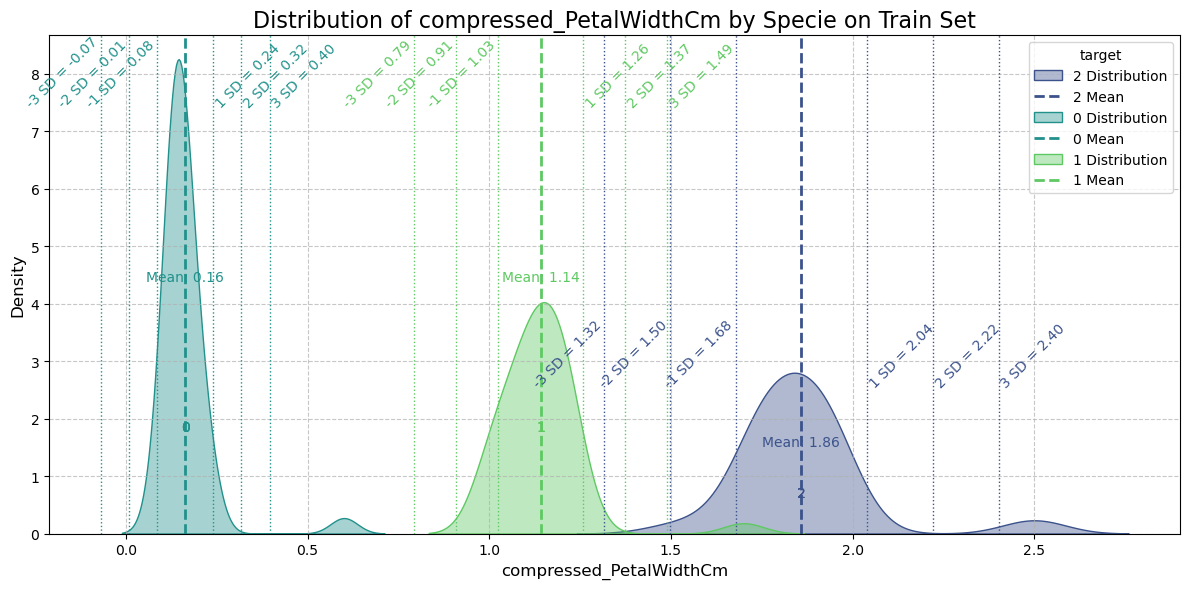

In [368]:
plot_distributions_of_feature_by_classes(
    general_df=compressed_train_df,
    feature_name='compressed_PetalWidthCm',
    target_name='target', 
    flag='train'
)

Analyse distribution of feature PetalWidthCm by classes on test set after compression

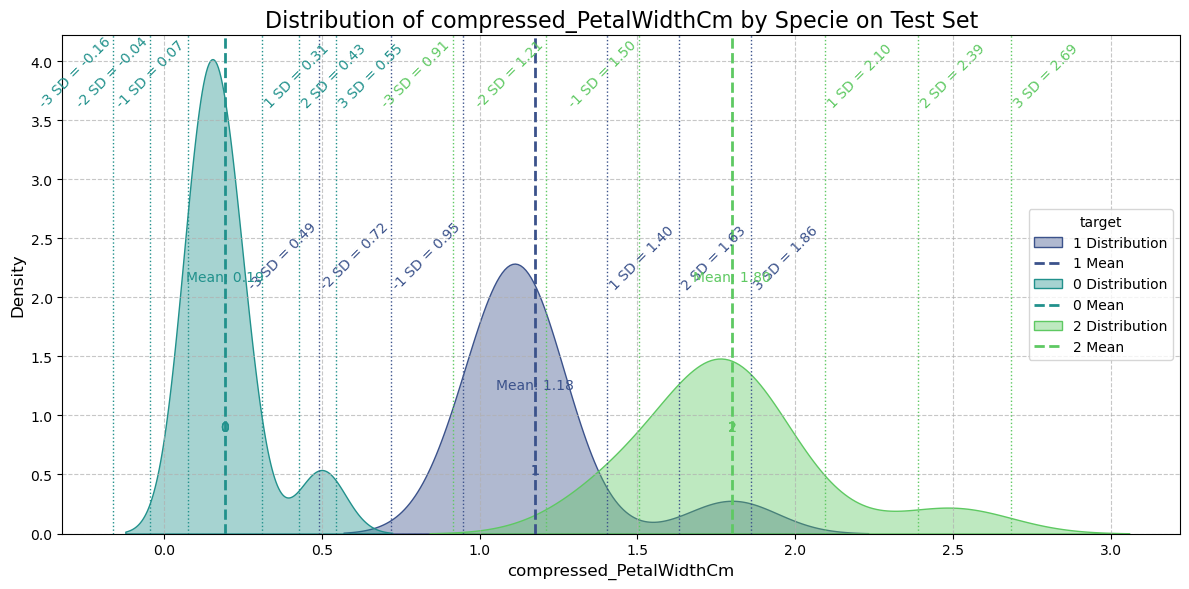

In [369]:
plot_distributions_of_feature_by_classes(
    general_df=compressed_test_df,
    feature_name='compressed_PetalWidthCm',
    target_name='target', 
    flag='test'
)

In [370]:
study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective_for_logistic_regression(
    trial=trial,
    X_train=compressed_train_df.drop(columns=['target']),
    y_train=compressed_train_df['target'],
    X_test=compressed_test_df.drop(columns=['target']),
    y_test=compressed_test_df['target']
), n_trials=50)

best_params = study.best_params
print(f'Best Hyperparameters: {best_params}')

working_model_without_petallength = LogisticRegression(**best_params, random_state=41)
working_model_without_petallength.fit(train_features_without_petallength, generated_train_species_labels)

working_train_without_petallength_df_with_predictions, working_train_without_petallength_accuracy, working_train_without_petallength_precision, working_train_without_petallength_recall, working_train_without_petallength_f1 = evaluate_model(train_features_without_petallength, generated_train_species_labels, working_model_without_petallength)
working_test_without_petallength_df_with_predictions, working_test_without_petallength_accuracy, working_test_without_petallength_precision, working_test_without_petallength_recall, working_test_without_petallength_f1 = evaluate_model(test_features_without_petallength, generated_test_species_labels, working_model_without_petallength)

print("Working model evaluation (without 'PetalLengthCm'):")
print(f"Train Accuracy: {working_train_without_petallength_accuracy:.4f}")
print(f"Train Precision: {working_train_without_petallength_precision:.4f}")
print(f"Train Recall: {working_train_without_petallength_recall:.4f}")
print(f"Train F1: {working_train_without_petallength_f1:.4f}")
print('---------------------')
print(f"Test Accuracy: {working_test_without_petallength_accuracy:.4f}")
print(f"Test Precision: {working_test_without_petallength_precision:.4f}")
print(f"Test Recall: {working_test_without_petallength_recall:.4f}")
print(f"Test F1: {working_test_without_petallength_f1:.4f}")

[I 2025-07-28 20:54:54,995] A new study created in memory with name: no-name-3dd301d3-bf5a-4001-bf6f-06da5ff9f77f
/Users/nikolaynechay/Iris-Species/src/core/helpers/optuna_objective.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-4, 1e2)
[I 2025-07-28 20:54:55,005] Trial 0 finished with value: 0.5555555555555555 and parameters: {'C': 0.0005807102377979597, 'penalty': 'l2', 'class_weight': 'balanced', 'max_iter': 720, 'solver': 'liblinear'}. Best is trial 0 with value: 0.5555555555555555.


/Users/nikolaynechay/Iris-Species/src/core/helpers/optuna_objective.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-4, 1e2)
[I 2025-07-28 20:54:55,011] Trial 1 finished with value: 0.7340930674264008 and parameters: {'C': 0.0004547014644328249, 'penalty': 'l2', 'class_weight': None, 'max_iter': 922, 'solver': 'saga'}. Best is trial 1 with value: 0.7340930674264008.
/Users/nikolaynechay/Iris-Species/src/core/helpers/optuna_objective.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-4, 1e2)
[I 2025-07-28 20:54:55,013] Trial 2 finished with value: 0.5555555555555555 and parameters: {'C': 0.00

Best Hyperparameters: {'C': 95.90560899787779, 'penalty': 'l2', 'class_weight': 'balanced', 'max_iter': 465, 'solver': 'liblinear'}
Working model evaluation (without 'PetalLengthCm'):
Train Accuracy: 0.9667
Train Precision: 0.9667
Train Recall: 0.9667
Train F1: 0.9667
---------------------
Test Accuracy: 0.9000
Test Precision: 0.9024
Test Recall: 0.9000
Test F1: 0.8997


### Error analysis

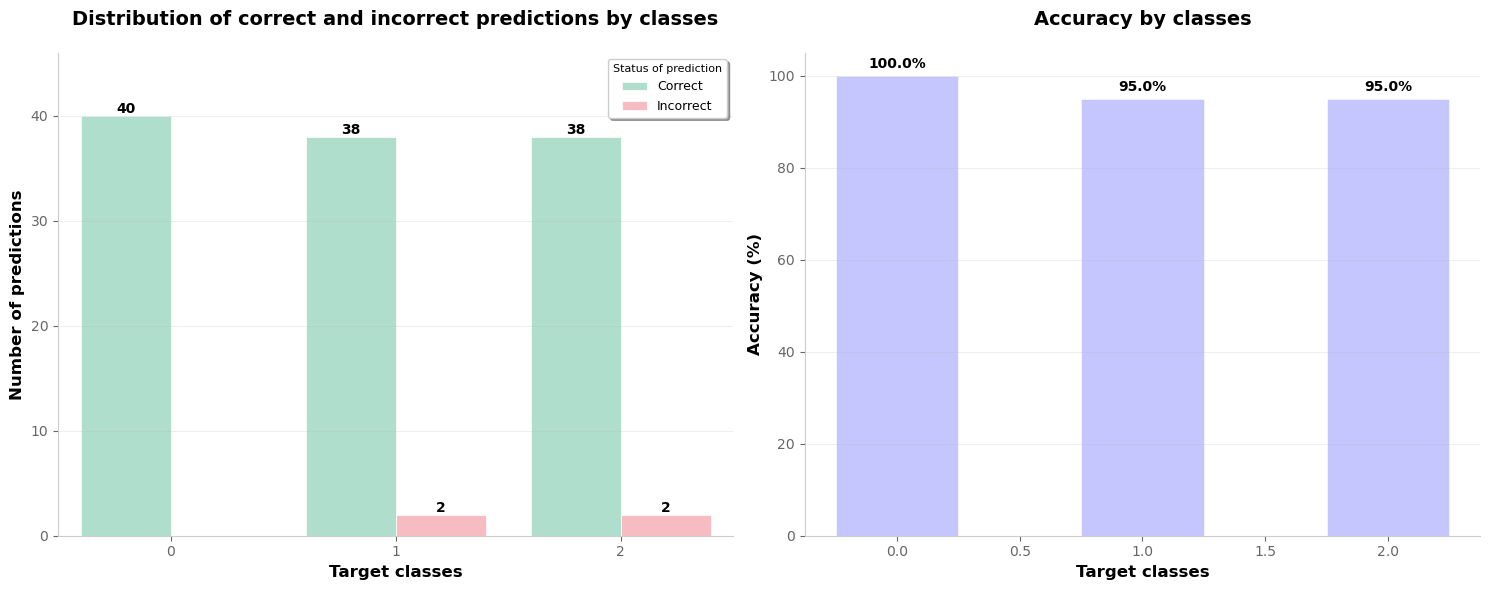

In [373]:
plot_error_distribution(working_train_without_petallength_df_with_predictions['predicted_label'], train_species_labels)


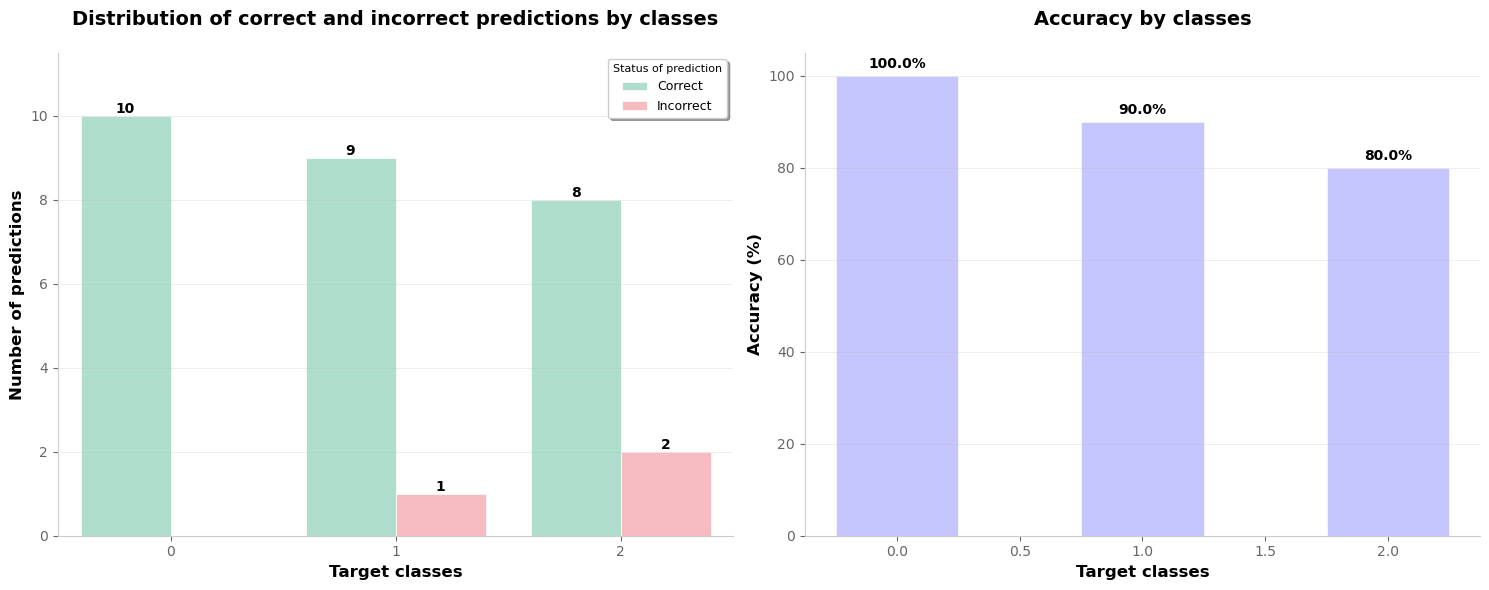

In [374]:
plot_error_distribution(working_test_without_petallength_df_with_predictions['predicted_label'], generated_test_species_labels)

### Model building 

In [372]:
print("Optimizing base Logistic Regression model with Optuna...")
base_study = optuna.create_study(direction='maximize')
base_study.optimize(lambda trial: objective_for_logistic_regression(
    trial=trial,
    X_train=train_features_without_petallength,
    y_train=generated_train_species_labels,
    X_test=test_features_without_petallength,
    y_test=generated_test_species_labels
), n_trials=50)

best_base_params = base_study.best_params
print(f'Best Hyperparameters for Base Logistic Regression: {best_base_params}')

print("\nOptimizing BaggingClassifier hyperparameters with Optuna...")
bagging_study = optuna.create_study(direction='maximize')
bagging_study.optimize(lambda trial: objective_for_bagging_classifier(
    trial=trial,
    X_train=train_features_without_petallength,
    y_train=generated_train_species_labels,
    best_base_params_lr=best_base_params
), n_trials=50)

best_bagging_params = bagging_study.best_params
print(f'Best Hyperparameters for BaggingClassifier: {best_bagging_params}')

print("\nTraining final Bagging Classifier with optimized parameters...")
final_base_logistic_regression_estimator = LogisticRegression(**best_base_params, random_state=41)

final_bagging_classifier = BaggingClassifier(
    estimator=final_base_logistic_regression_estimator,
    **best_bagging_params,
    random_state=41,
    n_jobs=-1
)

final_bagging_classifier.fit(
    X=train_features_without_petallength,
    y=generated_train_species_labels
)

print("\nEvaluating final Optimized Bagging model (without 'PetalLengthCm'):")
final_bagging_train_df_with_predictions, final_bagging_train_accuracy, final_bagging_train_precision, final_bagging_train_recall, final_bagging_train_f1 = \
    evaluate_model(train_features_without_petallength, generated_train_species_labels, final_bagging_classifier)

final_bagging_test_df_with_predictions, final_bagging_test_accuracy, final_bagging_test_precision, final_bagging_test_recall, final_bagging_test_f1 = \
    evaluate_model(test_features_without_petallength, generated_test_species_labels, final_bagging_classifier)

print(f"Train Accuracy (Optimized Bagging): {final_bagging_train_accuracy:.4f}")
print(f"Train Precision (Optimized Bagging): {final_bagging_train_precision:.4f}")
print(f"Train Recall (Optimized Bagging): {final_bagging_train_recall:.4f}")
print(f"Train F1 (Optimized Bagging): {final_bagging_train_f1:.4f}")
print('---------------------')
print(f"Test Accuracy (Optimized Bagging): {final_bagging_test_accuracy:.4f}")
print(f"Test Precision (Optimized Bagging): {final_bagging_test_precision:.4f}")
print(f"Test Recall (Optimized Bagging): {final_bagging_test_recall:.4f}")
print(f"Test F1 (Optimized Bagging): {final_bagging_test_f1:.4f}")

[I 2025-07-28 20:54:56,033] A new study created in memory with name: no-name-d252f919-d191-49a2-886f-47b39f095b93
/Users/nikolaynechay/Iris-Species/src/core/helpers/optuna_objective.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-4, 1e2)
[I 2025-07-28 20:54:56,099] Trial 0 finished with value: 0.16666666666666666 and parameters: {'C': 0.0004235254237306816, 'penalty': 'l1', 'class_weight': 'balanced', 'max_iter': 136, 'solver': 'liblinear'}. Best is trial 0 with value: 0.16666666666666666.
/Users/nikolaynechay/Iris-Species/src/core/helpers/optuna_objective.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_lo

Optimizing base Logistic Regression model with Optuna...


[I 2025-07-28 20:54:56,204] Trial 8 finished with value: 0.8997493734335839 and parameters: {'C': 57.51132629207778, 'penalty': 'l1', 'class_weight': 'balanced', 'max_iter': 482, 'solver': 'liblinear'}. Best is trial 4 with value: 0.8997493734335839.
/Users/nikolaynechay/Iris-Species/src/core/helpers/optuna_objective.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-4, 1e2)
[I 2025-07-28 20:54:56,206] Trial 9 finished with value: 0.16666666666666666 and parameters: {'C': 0.0003588891269816023, 'penalty': 'l1', 'class_weight': None, 'max_iter': 564, 'solver': 'liblinear'}. Best is trial 4 with value: 0.8997493734335839.
/Users/nikolaynechay/Iris-Species/src/core/helpers/optuna_objective.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in 

Best Hyperparameters for Base Logistic Regression: {'C': 62.1839447544882, 'penalty': 'l1', 'class_weight': 'balanced', 'max_iter': 102, 'solver': 'liblinear'}

Optimizing BaggingClassifier hyperparameters with Optuna...


/Users/nikolaynechay/anaconda3/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/nikolaynechay/anaconda3/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/nikolaynechay/anaconda3/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/nikolaynechay/anaconda3/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/nikolaynechay/anaconda3/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/nikolaynechay/anaconda3/lib/python3.12/site-pack

KeyboardInterrupt: 

In [ ]:
final_bagging_train_df_with_predictions.head()

SepalLengthCm  SepalWidthCm  PetalWidthCm  PetalRatio  SepalRatio  \
123            6.3           2.7           1.8    2.722222    2.333333   
106            4.9           2.5           1.7    2.647059    1.960000   
149            5.9           3.0           1.8    2.833333    1.966667   
10             5.4           3.7           0.2    7.500000    1.459459   
98             5.1           2.5           1.1    2.727273    2.040000   

     true_label  predicted_label  probability_of_0  probability_of_1  \
123           2                2             0.003             0.385   
106           2                2             0.010             0.291   
149           2                2             0.006             0.253   
10            0                0             0.954             0.046   
98            1                1             0.071             0.758   

     probability_of_2  is_correct  
123             0.612        True  
106             0.698        True  
149             0.741        True  
10              0.000        True  
98              0.171        True

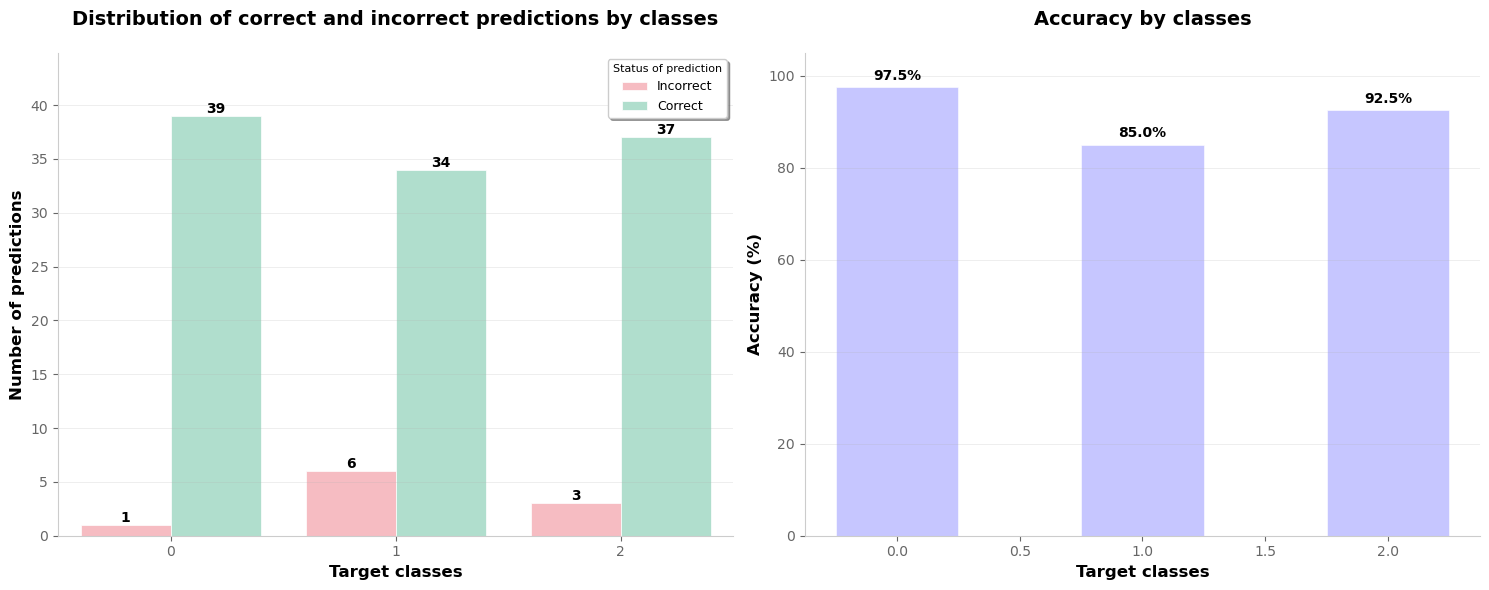

In [ ]:
plot_error_distribution(final_bagging_train_df_with_predictions['predicted_label'], generated_train_species_labels)

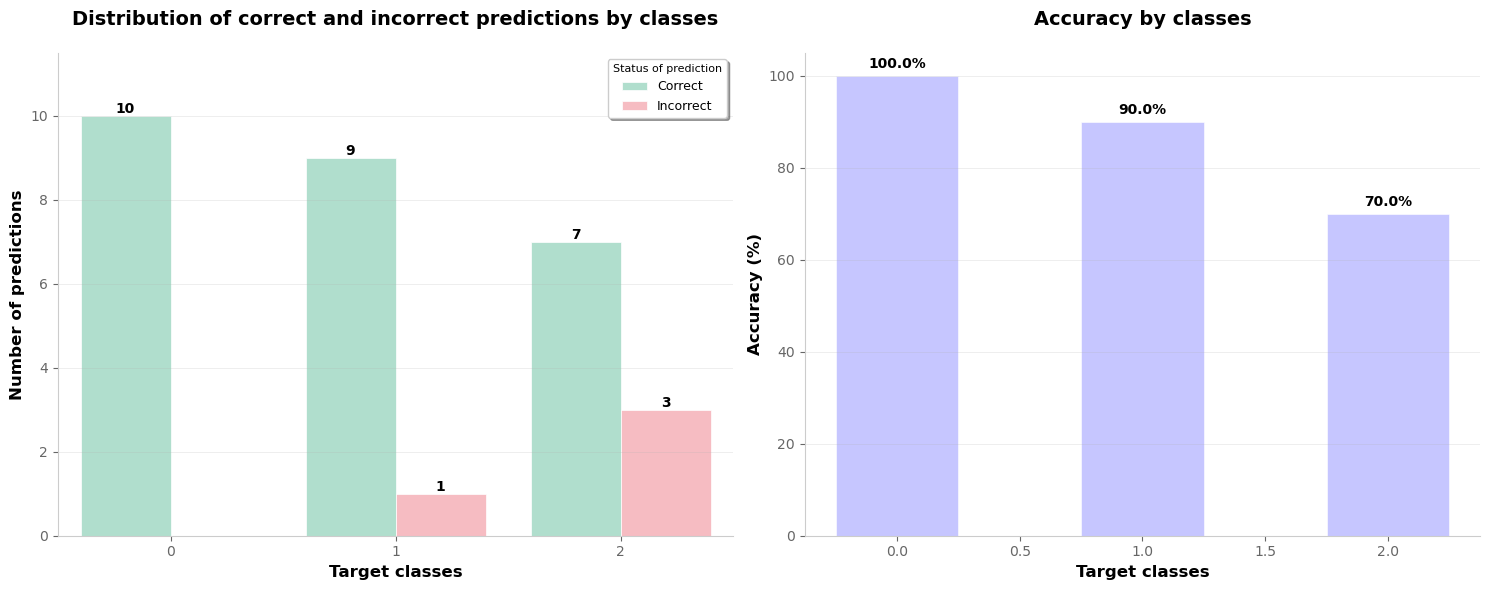

In [ ]:
plot_error_distribution(final_bagging_test_df_with_predictions['predicted_label'], generated_test_species_labels)

In [ ]:
final_bagging_train_df_without_petallength_errors = final_bagging_train_df_with_predictions[final_bagging_train_df_with_predictions['is_correct'] == False]
final_bagging_train_df_without_petallength_errors.iloc[:]

SepalLengthCm  SepalWidthCm  PetalWidthCm  PetalRatio  SepalRatio  \
77             6.7           3.0           1.7    2.941176    2.233333   
56             6.3           3.3           1.6    2.937500    1.909091   
66             5.6           3.0           1.5    3.000000    1.866667   
85             6.0           3.4           1.6    2.812500    1.764706   
129            7.2           3.0           1.6    3.625000    2.400000   
108            6.7           2.5           1.8    3.222222    2.680000   
84             5.4           3.0           1.5    3.000000    1.800000   
61             5.9           3.0           1.5    2.800000    1.966667   
119            6.0           2.2           1.5    3.333333    2.727273   
43             5.0           3.5           0.6    2.666667    1.428571   

     true_label  predicted_label  probability_of_0  probability_of_1  \
77            1                2             0.006             0.435   
56            1                2             0.016             0.395   
66            1                2             0.032             0.465   
85            1                2             0.018             0.318   
129           2                1             0.019             0.716   
108           2                1             0.003             0.519   
84            1                2             0.039             0.431   
61            1                2             0.018             0.474   
119           2                1             0.015             0.740   
43            0                1             0.419             0.560   

     probability_of_2  is_correct  
77              0.560       False  
56              0.589       False  
66              0.503       False  
85              0.664       False  
129             0.265       False  
108             0.477       False  
84              0.530       False  
61              0.508       False  
119             0.245       False  
43              0.021       False

In [ ]:
final_bagging_test_df_without_petallength_errors = final_bagging_test_df_with_predictions[final_bagging_test_df_with_predictions['is_correct'] == False]
final_bagging_test_df_without_petallength_errors.head()

SepalLengthCm  SepalWidthCm  PetalWidthCm  PetalRatio  SepalRatio  \
134            6.1           2.6           1.4    4.000000    2.346154   
70             5.9           3.2           1.8    2.666667    1.843750   
133            6.3           2.8           1.5    3.400000    2.250000   
107            7.3           2.9           1.8    3.500000    2.517241   

     true_label  predicted_label  probability_of_0  probability_of_1  \
134           2                1             0.086             0.827   
70            1                2             0.005             0.213   
133           2                1             0.028             0.697   
107           2                1             0.005             0.542   

     probability_of_2  is_correct  
134             0.087       False  
70              0.782       False  
133             0.275       False  
107             0.453       False